In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import SymLogNorm
from scipy.stats import norm,poisson,chi2
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.special import gammaln
plt.style.use("figures.mplstyle")

light_generators = ["EPOSLHC","DPMJET","SIBYLL","QGSJET","PYTHIA8"]
charm_generators = ["BKSS","BKRS","SIBYLL","BDGJKR","MS"]

colors = {("EPOSLHC","BKSS"):"mediumorchid",
          ("DPMJET","BKRS"):"deepskyblue",
          ("SIBYLL","SIBYLL"):"darkseagreen",
          ("QGSJET","BDGJKR"):"goldenrod",
          ("PYTHIA8","MS"):"indianred"
         }

forward_flux_files = {
    "LHC13":{
        "light":["DPMJET", "EPOSLHC", "PYTHIA8", "QGSJET", "SIBYLL"],
        "charm":["BDGJKR", "BKRS", "BKSS", "MS", "SIBYLL"]
    },
    "Large":{
        "light":["EPOSLHC"],
        "charm":["BKRS"]
    },
    "Run3":{
        "light":["EPOSLHC"],
        "charm":["POWHEG+P8monash"]
    },
    "VLarge":{
        "light":["EPOSLHC","SIBYLL"],
        "charm":["BKRS"]
    }
}
primaries = [12,-12,
             14,-14,
             16,-16
            ]
datasets={"SINE_CMS_West":["CC"],
          "UNDINE_LHCb_North":["CC","NC"],
           }

num_UNDINE = 10

yearly_factor = 250./3000. # 250 fb^-1 per year / 3 ab^-1 total
UNDINE_luminosity_factor = 380./3000. # LHCb luminosity v.s. CMS/ATLAS: https://arxiv.org/abs/1706.05990

UNDINE_electron_ebins = np.logspace(1.1,4.1,15)
UNDINE_muon_ebins = np.logspace(1.1,4.1,9)

In [2]:
data = {}
for detector,xs_models in datasets.items():
    for xs_model in xs_models:
        for prefix,parent_dict in forward_flux_files.items():
            if prefix!="LHC13": continue
            for parent,generators in parent_dict.items():
                for generator in generators:
                    for primary in primaries:
                        if "SINE" in detector and abs(primary)!=14: continue
                        if parent=="light" and abs(primary)==16: continue
                        key = tuple((detector,xs_model,prefix,generator,parent,primary))
                        print(key)
                        siren_output_file = "Data/SIREN/Output/%s/%s_%s_%s_%s_%s"%(detector,prefix,generator,parent,primary,xs_model)
                        compressed_output_file = "Data/SIREN/Output/%s/compressed/%s_%s_%s_%s_%s"%(detector,prefix,generator,parent,primary,xs_model)
                        # if "SINE" in detector: 
                        #     tmp_data = tmp_data[tmp_data.hit_mask_muon_survival]
                        # if "UNDINE" in detector: 
                        #     siren_output_file = "Data/SIREN/Output/%s/CSMS_%s_%s_%s_%s_%s"%(detector,prefix,generator,parent,primary,xs_model)
                        #     tmp_data = ak.from_parquet(siren_output_file+".parquet")
                        #     tmp_data = tmp_data[np.array(tmp_data.in_fiducial)[:,-1]]
                        #     ak.to_parquet(tmp_data,compressed_output_file+".parquet")
                        data[key] = ak.from_parquet(compressed_output_file+".parquet")
                

('SINE_CMS_West', 'CC', 'LHC13', 'DPMJET', 'light', 14)
('SINE_CMS_West', 'CC', 'LHC13', 'DPMJET', 'light', -14)
('SINE_CMS_West', 'CC', 'LHC13', 'EPOSLHC', 'light', 14)
('SINE_CMS_West', 'CC', 'LHC13', 'EPOSLHC', 'light', -14)
('SINE_CMS_West', 'CC', 'LHC13', 'PYTHIA8', 'light', 14)
('SINE_CMS_West', 'CC', 'LHC13', 'PYTHIA8', 'light', -14)
('SINE_CMS_West', 'CC', 'LHC13', 'QGSJET', 'light', 14)
('SINE_CMS_West', 'CC', 'LHC13', 'QGSJET', 'light', -14)
('SINE_CMS_West', 'CC', 'LHC13', 'SIBYLL', 'light', 14)
('SINE_CMS_West', 'CC', 'LHC13', 'SIBYLL', 'light', -14)
('SINE_CMS_West', 'CC', 'LHC13', 'BDGJKR', 'charm', 14)
('SINE_CMS_West', 'CC', 'LHC13', 'BDGJKR', 'charm', -14)
('SINE_CMS_West', 'CC', 'LHC13', 'BKRS', 'charm', 14)
('SINE_CMS_West', 'CC', 'LHC13', 'BKRS', 'charm', -14)
('SINE_CMS_West', 'CC', 'LHC13', 'BKSS', 'charm', 14)
('SINE_CMS_West', 'CC', 'LHC13', 'BKSS', 'charm', -14)
('SINE_CMS_West', 'CC', 'LHC13', 'MS', 'charm', 14)
('SINE_CMS_West', 'CC', 'LHC13', 'MS', 'charm', 

# paper figures from SIREN

In [3]:
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

EPOSLHC BKSS
DPMJET BKRS
SIBYLL SIBYLL
QGSJET BDGJKR
PYTHIA8 MS
EPOSLHC BKSS
DPMJET BKRS
SIBYLL SIBYLL
QGSJET BDGJKR
PYTHIA8 MS
EPOSLHC BKSS
DPMJET BKRS
SIBYLL SIBYLL
QGSJET BDGJKR
PYTHIA8 MS


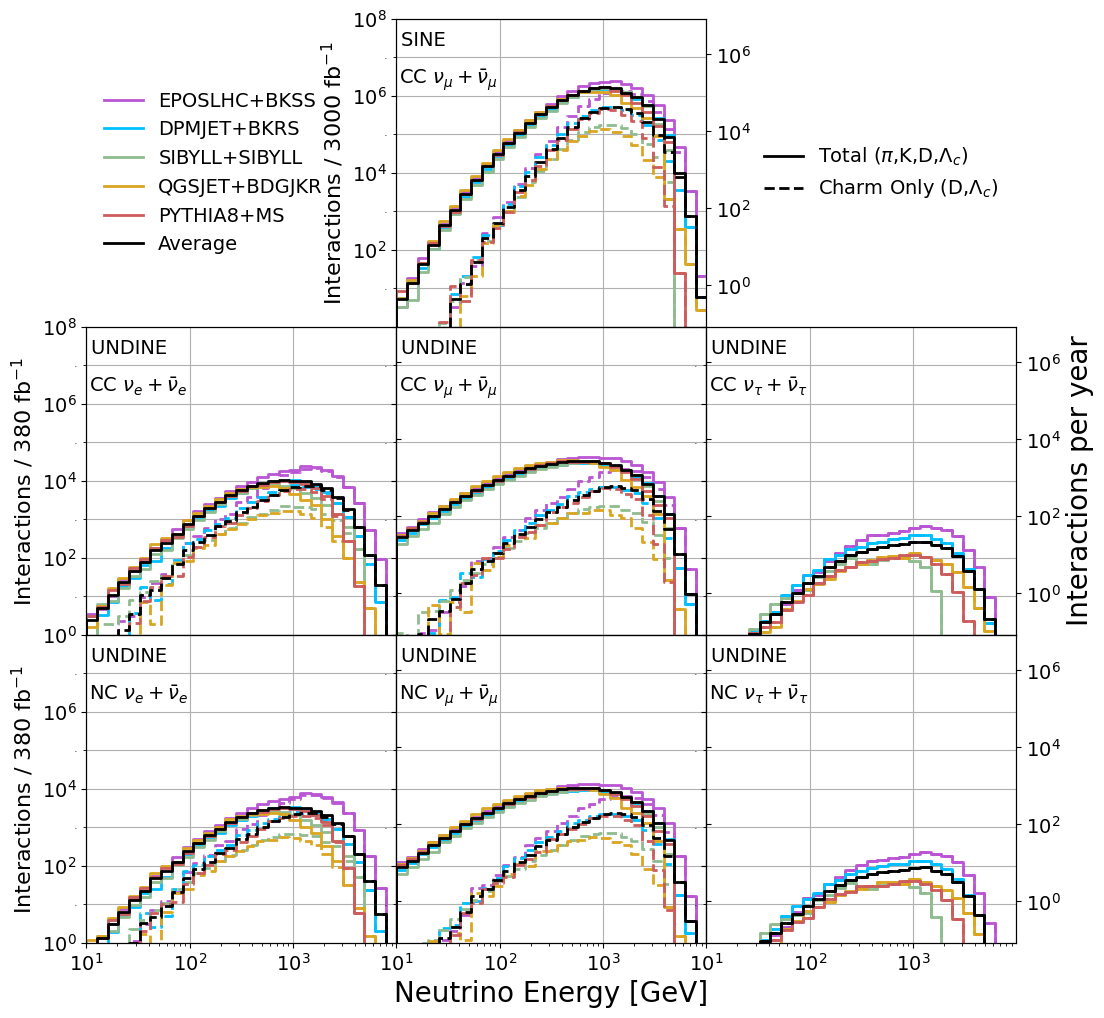

In [30]:
prefix = "LHC13"
light_generators = ["EPOSLHC","DPMJET","SIBYLL","QGSJET","PYTHIA8"]
charm_generators = ["BKSS","BKRS","SIBYLL","BDGJKR","MS"]

kaons = [
    130, # K0L
    310, # K0S
    321, # K+/-
    3312, # Theta+/-
    3122, # Lambda
    3112, # Sigma-
    3222, # Sigma+
    3322, # Theta0
    ]

pions = [
    211, # pi+/-
]


fig,ax = plt.subplots(3,3,figsize=(12,12))
fig.set_facecolor("white")

twin_ax = np.empty_like(ax)
for i in range(3):
    for j in range(3):
        twin_ax[i,j] = ax[i,j].twinx()
        

fig.subplots_adjust(wspace=0, hspace=0)
ax[0,0].axis("off")
ax[0,2].axis("off")
twin_ax[0,0].axis("off")
twin_ax[0,2].axis("off")

Ebins = np.logspace(1,4,30)
pids = [12,14,16]



total_rates = {}
generator_rates = {}
generator_pion_rates = {}
generator_kaon_rates = {}
generator_UNDINE_electron_edist= {}
generator_UNDINE_muon_edist = {}
generator_UNDINE_electron_pion_edist = {}
generator_UNDINE_muon_pion_edist = {}
generator_UNDINE_electron_kaon_edist = {}
generator_UNDINE_muon_kaon_edist = {}

# SINE_numu_Erange = []
# UNDINE_numu_Erange = []
# UNDINE_nue_Erange = []

i = -1
for det,xs_models in datasets.items():
    
    for xs_model in xs_models:
        
        i += 1
        
        Ehist_l_avg = {pid:np.zeros(len(Ebins)-1) for pid in pids}
        Ehist_c_avg = {pid:np.zeros(len(Ebins)-1) for pid in pids}
        Ehist_avg = {pid:np.zeros(len(Ebins)-1) for pid in pids}

        for lg,cg in zip(light_generators,charm_generators):

            c = colors[(lg,cg)]
            print(lg,cg)

            lkey = tuple((det,xs_model,prefix,lg,"light"))
            ckey = tuple((det,xs_model,prefix,cg,"charm"))



            for iax,pid in enumerate(pids):



                if pid!=16 and not (pid!=14 and "SINE" in det):
                    ldata = ak.concatenate([data[lkey+(pid,)],data[lkey+(-pid,)]])
                    lweights = np.array(ldata.weights)
                    if "SINE" in det: lweights *= np.array(ldata.hit_mask_muon_survival)
                    if "UNDINE" in det: lweights *= UNDINE_luminosity_factor*num_UNDINE*np.array(ldata.in_fiducial)[:,-1]
                    #vx = np.squeeze(ldata.vertex)
                    Ehist_l,_ = np.histogram(ldata.energy,bins=Ebins,weights=lweights)
                    generator_rates[lkey+(pid,)] = sum(lweights)
                    generator_UNDINE_electron_edist[lkey+(pid,)],_ = np.histogram(ldata.energy,bins=UNDINE_electron_ebins,weights=lweights)
                    generator_UNDINE_muon_edist[lkey+(pid,)],_ = np.histogram(ldata.energy,bins=UNDINE_muon_ebins,weights=lweights)
                    pion_indices = np.isin(np.abs(np.array(ldata.hPDG,dtype=int)),pions)
                    kaon_indices = np.isin(np.abs(np.array(ldata.hPDG,dtype=int)),kaons)
                    pion_weights = lweights[pion_indices]
                    kaon_weights = lweights[kaon_indices]
                    generator_pion_rates[lkey+(pid,)] = sum(pion_weights)
                    generator_kaon_rates[lkey+(pid,)] = sum(kaon_weights)
                    generator_UNDINE_electron_pion_edist[lkey+(pid,)],_ = np.histogram(ldata.energy[pion_indices],bins=UNDINE_electron_ebins,weights=pion_weights)
                    generator_UNDINE_muon_pion_edist[lkey+(pid,)],_ = np.histogram(ldata.energy[pion_indices],bins=UNDINE_muon_ebins,weights=pion_weights)
                    generator_UNDINE_electron_kaon_edist[lkey+(pid,)],_ = np.histogram(ldata.energy[kaon_indices],bins=UNDINE_electron_ebins,weights=kaon_weights)
                    generator_UNDINE_muon_kaon_edist[lkey+(pid,)],_ = np.histogram(ldata.energy[kaon_indices],bins=UNDINE_muon_ebins,weights=kaon_weights)
                else:
                    Ehist_l = np.zeros(len(Ebins)-1)
                    generator_rates[lkey+(pid,)] = 0
                    generator_pion_rates[lkey+(pid,)] = 0
                    generator_kaon_rates[lkey+(pid,)] = 0
                    generator_UNDINE_electron_edist[lkey+(pid,)] = np.zeros(len(UNDINE_electron_ebins)-1)
                    generator_UNDINE_muon_edist[lkey+(pid,)] = np.zeros(len(UNDINE_muon_ebins)-1)
                    generator_UNDINE_electron_pion_edist[lkey+(pid,)] = np.zeros(len(UNDINE_electron_ebins)-1)
                    generator_UNDINE_muon_pion_edist[lkey+(pid,)] = np.zeros(len(UNDINE_muon_ebins)-1)
                    generator_UNDINE_electron_kaon_edist[lkey+(pid,)] = np.zeros(len(UNDINE_electron_ebins)-1)
                    generator_UNDINE_muon_kaon_edist[lkey+(pid,)] = np.zeros(len(UNDINE_muon_ebins)-1)
                if not (pid!=14 and "SINE" in det):
                    cdata = ak.concatenate([data[ckey+(pid,)],data[ckey+(-pid,)]])
                    cweights = np.array(cdata.weights)
                    if "SINE" in det: cweights *= np.array(cdata.hit_mask_muon_survival)
                    if "UNDINE" in det: cweights *= UNDINE_luminosity_factor*num_UNDINE*np.array(cdata.in_fiducial)[:,-1]
                    #vx = np.squeeze(cdata.vertex)
                    Ehist_c,_ = np.histogram(cdata.energy,bins=Ebins,weights=cweights)
                    generator_rates[ckey+(pid,)] = sum(cweights)
                    generator_UNDINE_electron_edist[ckey+(pid,)],_ = np.histogram(cdata.energy,bins=UNDINE_electron_ebins,weights=cweights)
                    generator_UNDINE_muon_edist[ckey+(pid,)],_ = np.histogram(cdata.energy,bins=UNDINE_muon_ebins,weights=cweights)
                    pion_indices = np.isin(np.abs(np.array(cdata.hPDG,dtype=int)),pions)
                    kaon_indices = np.isin(np.abs(np.array(cdata.hPDG,dtype=int)),kaons)
                    pion_weights = cweights[pion_indices]
                    kaon_weights = cweights[kaon_indices]
                    generator_pion_rates[ckey+(pid,)] = sum(pion_weights)
                    generator_kaon_rates[ckey+(pid,)] = sum(kaon_weights)
                    generator_UNDINE_electron_pion_edist[ckey+(pid,)],_ = np.histogram(cdata.energy[pion_indices],bins=UNDINE_electron_ebins,weights=pion_weights)
                    generator_UNDINE_muon_pion_edist[ckey+(pid,)],_ = np.histogram(cdata.energy[pion_indices],bins=UNDINE_muon_ebins,weights=pion_weights)
                    generator_UNDINE_electron_kaon_edist[ckey+(pid,)],_ = np.histogram(cdata.energy[kaon_indices],bins=UNDINE_electron_ebins,weights=kaon_weights)
                    generator_UNDINE_muon_kaon_edist[ckey+(pid,)],_ = np.histogram(cdata.energy[kaon_indices],bins=UNDINE_muon_ebins,weights=kaon_weights)
                else:
                    Ehist_c = np.zeros(len(Ebins)-1)
                    generator_rates[ckey+(pid,)] = 0
                    generator_pion_rates[ckey+(pid,)] = 0
                    generator_kaon_rates[ckey+(pid,)] = 0
                    generator_UNDINE_electron_edist[ckey+(pid,)] = np.zeros(len(UNDINE_electron_ebins)-1)
                    generator_UNDINE_muon_edist[ckey+(pid,)] = np.zeros(len(UNDINE_muon_ebins)-1)
                    generator_UNDINE_electron_pion_edist[ckey+(pid,)] = np.zeros(len(UNDINE_electron_ebins)-1)
                    generator_UNDINE_muon_pion_edist[ckey+(pid,)] = np.zeros(len(UNDINE_muon_ebins)-1)
                    generator_UNDINE_electron_kaon_edist[ckey+(pid,)] = np.zeros(len(UNDINE_electron_ebins)-1)
                    generator_UNDINE_muon_kaon_edist[ckey+(pid,)] = np.zeros(len(UNDINE_muon_ebins)-1)


                # if cg=="BKRS" and xs_model=="CC":
                #     q1 = 0.5 - 2*(1-norm.cdf(1))
                #     q2 = 0.5 + 2*(1-norm.cdf(1))
                #     if "SINE" in det and pid==14:
                #         SINE_numu_Erange = weighted_quantile(list(ldata.energy)+list(cdata.energy),[q1,q2],sample_weight=list(lweights)+list(cweights))
                #     if "UNDINE" in det and pid==12:
                #         UNDINE_nue_Erange = weighted_quantile(list(ldata.energy)+list(cdata.energy),[q1,q2],sample_weight=list(lweights)+list(cweights))
                #     if "UNDINE" in det and pid==14:
                #         UNDINE_numu_Erange = weighted_quantile(list(ldata.energy)+list(cdata.energy),[q1,q2],sample_weight=list(lweights)+list(cweights))
                    
                            
                
                Ehist = np.array(Ehist_l+Ehist_c)
                Ehist_avg[pid] += Ehist/len(light_generators)
                Ehist_l_avg[pid] += np.array(Ehist_l)/len(light_generators)
                Ehist_c_avg[pid] += np.array(Ehist_c)/len(charm_generators)
                if i==0 and iax==0:
                    ax[i,iax].step([],[],color=c,label="%s+%s"%(lg,cg))
                elif i!=0 or iax !=2:
                    ax[i,iax].step(Ebins,np.append([0],Ehist),color=c,lw=2)
                    ax[i,iax].step(Ebins,np.append([0],Ehist_c),color=c,ls="--",lw=2)

        for iax,pid in enumerate(pids):
            total_rates[tuple((det,xs_model,"light",pid))] = sum(Ehist_l_avg[pid])
            total_rates[tuple((det,xs_model,"charm",pid))] = sum(Ehist_c_avg[pid])    
            if not(i==0 and iax!=1):
                ax[i,iax].step(Ebins,np.append([0],Ehist_c_avg[pid]),color="black",ls="--")
                ax[i,iax].step(Ebins,np.append([0],Ehist_avg[pid]),color="black")
            elif i==0 and iax==0:
                 ax[i,iax].plot([],[],label="Average",color="black")
            
ax[2,1].set_xlabel("Neutrino Energy [GeV]",fontsize=20)
ax[0,1].set_ylabel(r"Interactions / $3000~{\rm fb}^{-1}$",fontsize=16)
ax[1,0].set_ylabel(r"Interactions / $%d~{\rm fb}^{-1}$"%(UNDINE_luminosity_factor*3000),fontsize=16)
ax[2,0].set_ylabel(r"Interactions / $%d~{\rm fb}^{-1}$"%(UNDINE_luminosity_factor*3000),fontsize=16)
twin_ax[1,2].set_ylabel(r"Interactions per year",fontsize=20)
ax[0,2].plot([],[],color="black",label=r"Total ($\pi$,K,D,$\Lambda_c$)")
#ax[0,2].plot([],[],color="black",ls='--',label=r"$\pi$,K")
ax[0,2].plot([],[],color="black",ls='--',label=r"Charm Only (D,$\Lambda_c$)")
ax[0,0].legend(loc="center left",fontsize=14)
ax[0,2].legend(loc="center right",fontsize=14)

det_labels = ["SINE CC","UNDINE CC", "UNDINE NC"]
particle_labels = [r"$\nu_e+\bar{\nu}_e$",
                   r"$\nu_\mu+\bar{\nu}_\mu$",
                   r"$\nu_\tau+\bar{\nu}_\tau$"]
for i in [0,1,2]:
    for j in [0,1,2]:
            
        ax[i,j].set_xlim(1e1,Ebins[-1])
        ax[i,j].set_ylim(1e0,1e8)
        ax[i,j].set_xlim(1e1,1e4)
        ax[i,j].tick_params(axis='both', which='major', labelsize=14)
        ax[i,j].tick_params(axis='both', which='minor', labelsize=0)
        twin_ax[i,j].tick_params(axis='both', which='major', labelsize=14)
        ax[i,j].get_xaxis().grid(True,which='major')
        ax[i,j].get_yaxis().grid(True,which='both')
        
        if not(i==0 and j in [0,2]):
            ax[i,j].text(11,2e7,det_labels[i][:-2],fontsize=14)
            ax[i,j].text(10.5,2e6,det_labels[i][-2:]+" "+ particle_labels[j],fontsize=14)
            ax[i,j].loglog()
            mn, mx = ax[i,j].get_ylim()
            twin_ax[i,j].set_ylim(mn*yearly_factor, mx*yearly_factor)
            twin_ax[i,j].loglog()
        
        # xticks
        if i!=2: 
            ax[i,j].set_xticklabels([])
        if i!= 0: 
            ax[i,j].set_xticks(np.logspace(1,3,3))
        
        # yticks
        if i==0 and j==1:
            ax[i,j].set_yticks(np.logspace(2,8,4))
            ax[i,j].set_yticks(np.logspace(1,8,8),minor=True)
        elif i==1 and j==0:
            ax[i,j].set_yticks(np.logspace(0,8,5))
            ax[i,j].set_yticks(np.logspace(0,8,9),minor=True)
        elif i==2 and j==0:
            ax[i,j].set_yticks(np.logspace(0,6,4))
            ax[i,j].set_yticks(np.logspace(0,7,8),minor=True)
        else:
            ax[i,j].set_yticks(np.logspace(0,8,9),minor=True)
            ax[i,j].set_yticklabels([])
        
        if (i==0 and j==1) or (j==2 and i in [1,2]):
            twin_ax[i,j].set_yticks(np.logspace(0,6,4))
        else:
            twin_ax[i,j].set_yticklabels([])

plt.savefig("Figures/SIREN/Distributions.pdf",dpi=100)
plt.show()
            

In [5]:
for detector,xs_models in datasets.items():
    for xs_model in xs_models:
        if xs_model=="NC":
            rate_light = 0
            rate_charm = 0
            for pid in pids:
                rate_light += total_rates[tuple((detector,xs_model,"light",pid))]
                rate_charm += total_rates[tuple((detector,xs_model,"charm",pid))]
            print("%s (%s %s) & %s & %s & %s \\\\"%("SINE" if "SINE" in detector else "UNDINE",
                                               xs_model,"$\\nu_\\alpha + \\bar{\\nu}_\\alpha$",
                                               "$10^{%1.2f}$"%np.log10(rate_light+rate_charm),
                                               "$10^{%1.2f}$"%np.log10(rate_light) if rate_light > 0 else "0",
                                               "$10^{%1.2f}$"%np.log10(rate_charm)))
        else:
            for pid,pid_label in zip(pids,particle_labels):
                if pid!=14 and "SINE" in detector: continue
                rate_light = total_rates[tuple((detector,xs_model,"light",pid))]
                rate_charm = total_rates[tuple((detector,xs_model,"charm",pid))]

                print("%s (%s %s) & %s & %s & %s \\\\"%("SINE" if "SINE" in detector else "UNDINE",
                       xs_model,pid_label,
                       "$10^{%1.2f}$"%np.log10(rate_light+rate_charm),
                       "$10^{%1.2f}$"%np.log10(rate_light) if rate_light > 0 else "0",
                       "$10^{%1.2f}$"%np.log10(rate_charm)))
                

SINE (CC $\nu_\mu+\bar{\nu}_\mu$) & $10^{7.09}$ & $10^{6.96}$ & $10^{6.50}$ \\
UNDINE (CC $\nu_e+\bar{\nu}_e$) & $10^{4.98}$ & $10^{4.62}$ & $10^{4.72}$ \\
UNDINE (CC $\nu_\mu+\bar{\nu}_\mu$) & $10^{5.57}$ & $10^{5.51}$ & $10^{4.71}$ \\
UNDINE (CC $\nu_\tau+\bar{\nu}_\tau$) & $10^{3.38}$ & 0 & $10^{3.38}$ \\
UNDINE (NC $\nu_\alpha + \bar{\nu}_\alpha$) & $10^{5.17}$ & $10^{5.06}$ & $10^{4.54}$ \\


# Charm production model sensitivity

/tmp/ipykernel_2098424/3489854547.py:37: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[i,j].semilogy()
/tmp/ipykernel_2098424/3489854547.py:39: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[i,j].set_ylim(1,3e3)


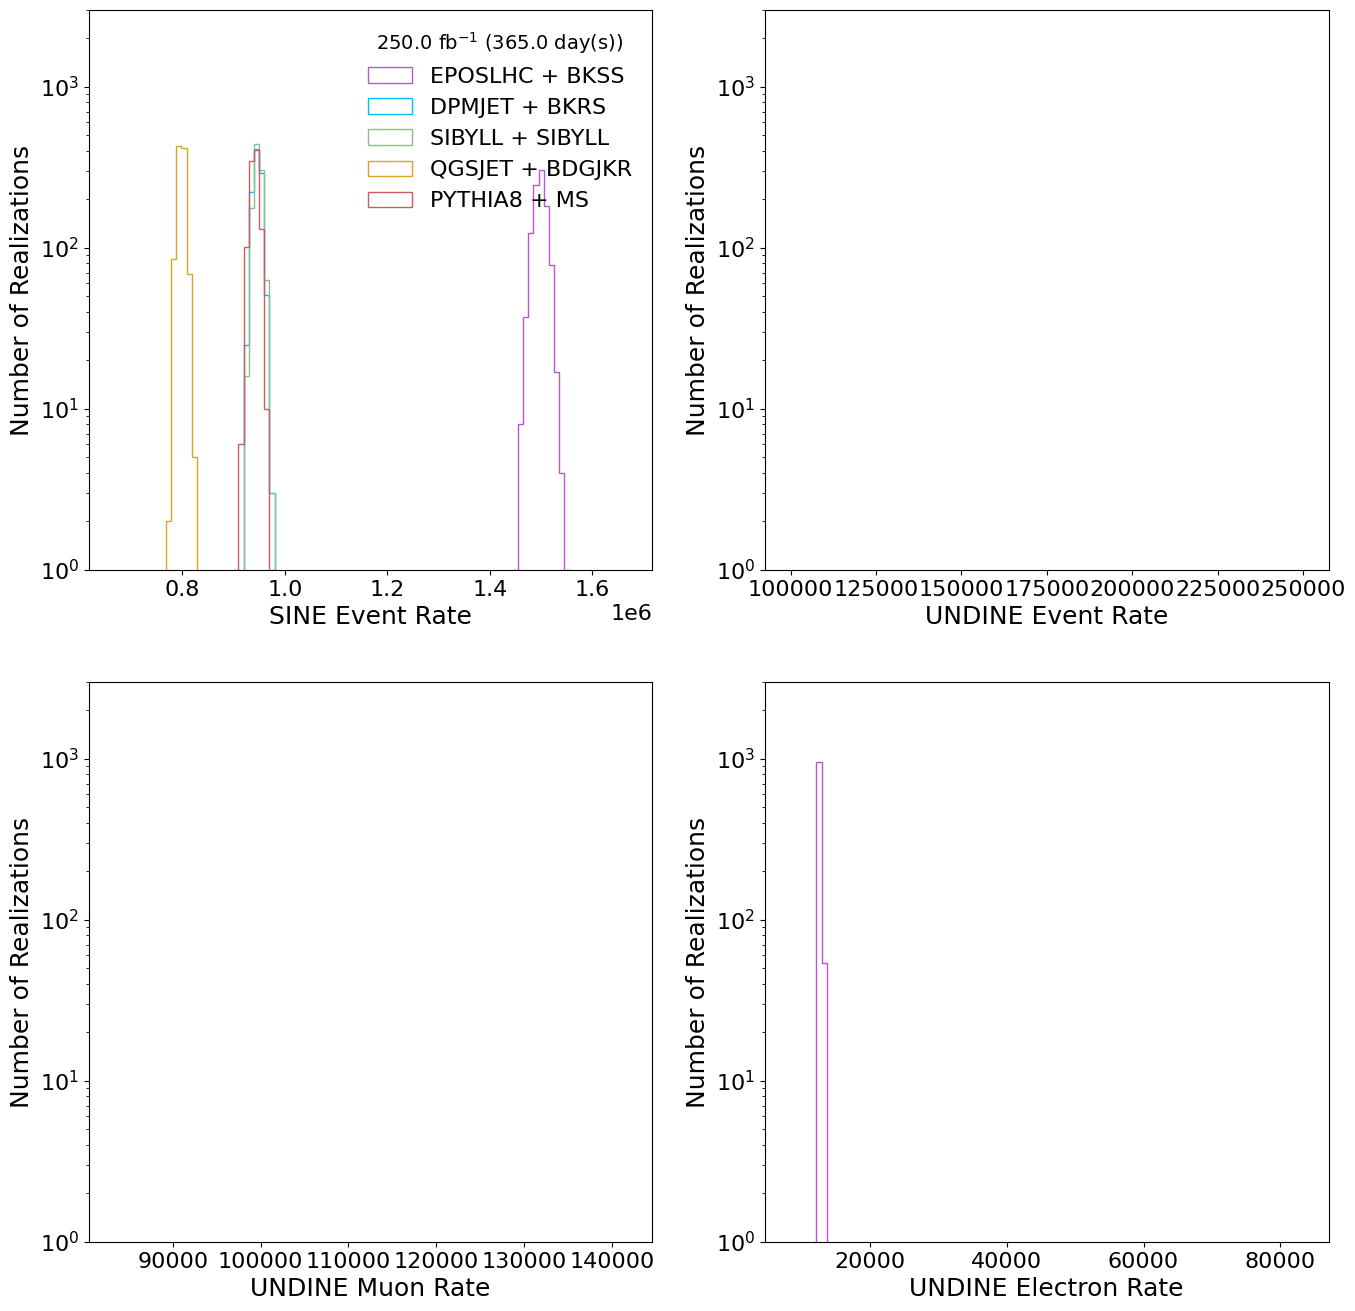

In [6]:

exposure_factor = yearly_factor # roughly one month
r1_unc = {}
r2_unc = {}
fig,ax = plt.subplots(2,2,figsize=(16,16))
pseudoexp_dir = "/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/Geneva/Lake_Geneva_Neutrinos/Data/SIREN/Output/Pseudoexperiments"
for lg,cg in zip(light_generators,charm_generators):
    c = colors[(lg,cg)]
    SINE_Total = np.load("%s/SINE_Total_All_%s_%s.npy"%(pseudoexp_dir,lg,cg))
    UNDINE_Total = UNDINE_luminosity_factor*num_UNDINE*np.load("%s/UNDINE_Total_All_%s_%s.npy"%(pseudoexp_dir,lg,cg))
    UNDINE_muons = UNDINE_luminosity_factor*num_UNDINE*np.load("%s/UNDINE_muons_All_%s_%s.npy"%(pseudoexp_dir,lg,cg))
    UNDINE_electrons = UNDINE_luminosity_factor*num_UNDINE*np.load("%s/UNDINE_electrons_All_%s_%s.npy"%(pseudoexp_dir,lg,cg))
    SINE_Total_realizations = np.random.poisson(lam=exposure_factor*SINE_Total)
    UNDINE_Total_realizations = np.random.poisson(lam=exposure_factor*UNDINE_Total)
    UNDINE_muons_realizations = np.random.poisson(lam=exposure_factor*UNDINE_muons)
    UNDINE_electrons_realizations = np.random.poisson(lam=exposure_factor*UNDINE_electrons)
    #print(SINE_Total,SINE_Total_realizations)
    ax[0,0].hist(SINE_Total_realizations,bins=np.linspace(exposure_factor*8e6,exposure_factor*2e7,100),color=c,histtype="step",label="%s + %s"%(lg,cg))
    ax[0,1].hist(UNDINE_Total_realizations,bins=np.linspace(exposure_factor*1.2e6,exposure_factor*3e6,100),color=c,histtype="step",label="%s + %s"%(lg,cg))
    ax[1,0].hist(UNDINE_muons_realizations,bins=np.linspace(exposure_factor*1e6,exposure_factor*1.7e6,100),color=c,histtype="step",label="%s + %s"%(lg,cg))
    ax[1,1].hist(UNDINE_electrons_realizations,bins=np.linspace(exposure_factor*1e5,exposure_factor*1e6,100),color=c,histtype="step",label="%s + %s"%(lg,cg))
    r1 = np.sort(SINE_Total/UNDINE_Total,)
    r2 = np.sort(UNDINE_muons/UNDINE_electrons)
    r1_unc[(lg,cg)] = {}
    r2_unc[(lg,cg)] = {}
    for sigma in [1,2,3]:
        low_cl = (2*(1-norm.cdf(sigma)))
        high_cl = 1 - low_cl
        for r,r_unc in zip([r1,r2],[r1_unc[(lg,cg)],r2_unc[(lg,cg)]]):
            r_down = np.median(r) - r[int(low_cl*len(r))]
            r_up = r[int(high_cl*len(r))] - np.median(r)
            r_unc[sigma] = (r_down,r_up)
#plt.xlim(exposure_factor*6e6,exposure_factor*2.5e7)
#plt.ylim(1,1e3)
ax[0,0].legend(title="%2.1f fb$^{-1}$ (%2.1f day(s))"%(3000*exposure_factor,exposure_factor/yearly_factor*365))
for i in range(2):
    for j in range(2):
        ax[i,j].semilogy()
        ax[i,j].set_ylabel("Number of Realizations")
        ax[i,j].set_ylim(1,3e3)
ax[0,0].set_xlabel(r"SINE Event Rate")
ax[0,1].set_xlabel(r"UNDINE Event Rate")
ax[1,0].set_xlabel(r"UNDINE Muon Rate")
ax[1,1].set_xlabel(r"UNDINE Electron Rate")
plt.show()

EPOSLHC BKSS
DPMJET BKRS
SIBYLL SIBYLL
QGSJET BDGJKR
PYTHIA8 MS


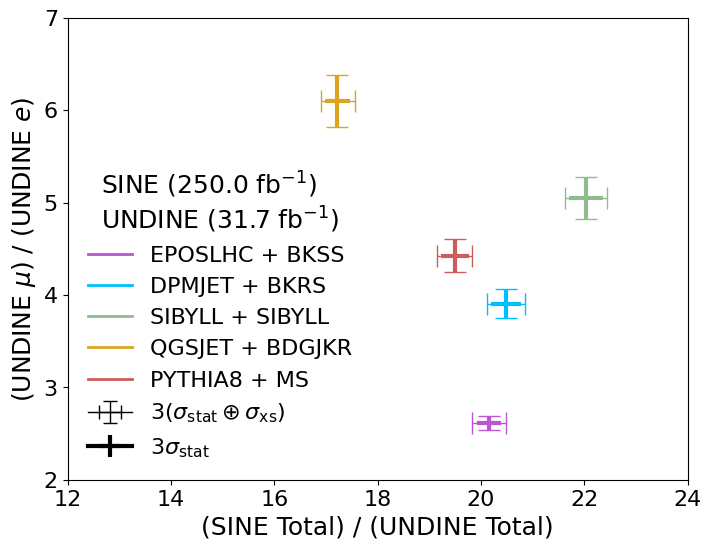

In [36]:
tau_muon_BR = 0#0.1739
norm_error = 0.03
exposure_factor = yearly_factor # roughly one month
nsigma = 3

SINE_rate_nominal = {}
UNDINE_rate_nominal = {}
UNDINE_muons_nominal = {}
UNDINE_electrons_nominal = {}
UNDINE_muons_edist_nominal = {}
UNDINE_electrons_edist_nominal = {}
for lg,cg in zip(light_generators,charm_generators):

    c = colors[(lg,cg)]
    print(lg,cg)
    
    SINE_rate_nominal[(lg,cg)] = {}
    UNDINE_rate_nominal[(lg,cg)] = {}
    UNDINE_muons_nominal[(lg,cg)] = {}
    UNDINE_electrons_nominal[(lg,cg)] = {}
    UNDINE_muons_edist_nominal[(lg,cg)] = {}
    UNDINE_electrons_edist_nominal[(lg,cg)] = {}

    # SINE overall rate
    lkey = tuple(("SINE_CMS_West","CC",prefix,lg,"light"))
    ckey = tuple(("SINE_CMS_West","CC",prefix,cg,"charm"))
    SINE_rate = generator_rates[lkey+(14,)] + generator_rates[ckey+(14,)]
    SINE_rate_pions = generator_pion_rates[lkey+(14,)]
    SINE_rate_kaons = generator_kaon_rates[lkey+(14,)]
    SINE_rate_charm = generator_rates[ckey+(14,)]

    # UNDINE overall rate and energy distributions
    UNDINE_rate = 0
    UNDINE_muons = 0
    UNDINE_electrons = 0
    UNDINE_edist_muons = 0
    UNDINE_edist_electrons = 0
    
    UNDINE_rate_pions = 0
    UNDINE_muons_pions = 0
    UNDINE_electrons_pions = 0
    UNDINE_edist_muons_pions = 0
    UNDINE_edist_electrons_pions = 0
    
    UNDINE_rate_kaons = 0
    UNDINE_muons_kaons = 0
    UNDINE_electrons_kaons = 0
    UNDINE_edist_muons_kaons = 0
    UNDINE_edist_electrons_kaons = 0
    
    UNDINE_rate_charm = 0
    UNDINE_muons_charm = 0
    UNDINE_electrons_charm = 0
    UNDINE_edist_muons_charm = 0
    UNDINE_edist_electrons_charm = 0
    
    for xs_model in datasets["UNDINE_LHCb_North"]:
        lkey = tuple(("UNDINE_LHCb_North",xs_model,prefix,lg,"light"))
        ckey = tuple(("UNDINE_LHCb_North",xs_model,prefix,cg,"charm"))
        for pid in pids:
            
            #rates
            rate = generator_rates[lkey+(pid,)] + generator_rates[ckey+(pid,)]
            pion_rate = generator_pion_rates[lkey+(pid,)]
            kaon_rate = generator_kaon_rates[lkey+(pid,)]
            charm_rate = generator_rates[ckey+(pid,)]
            UNDINE_rate += rate
            UNDINE_rate_pions += pion_rate
            UNDINE_rate_kaons += kaon_rate
            UNDINE_rate_charm += charm_rate
            
            #energy distributions
            electron_edist = np.array(generator_UNDINE_electron_edist[lkey+(pid,)] + generator_UNDINE_electron_edist[ckey+(pid,)])
            electron_pion_edist = np.array(generator_UNDINE_electron_pion_edist[lkey+(pid,)])
            electron_kaon_edist = np.array(generator_UNDINE_electron_kaon_edist[lkey+(pid,)])
            electron_charm_edist = np.array(generator_UNDINE_electron_edist[ckey+(pid,)])
            muon_edist = np.array(generator_UNDINE_muon_edist[lkey+(pid,)] + generator_UNDINE_muon_edist[ckey+(pid,)])
            muon_pion_edist = np.array(generator_UNDINE_muon_pion_edist[lkey+(pid,)])
            muon_kaon_edist = np.array(generator_UNDINE_muon_kaon_edist[lkey+(pid,)])
            muon_charm_edist = np.array(generator_UNDINE_muon_edist[ckey+(pid,)])
            
            
            
            if xs_model=="CC" and pid==14:
                UNDINE_muons += rate
                UNDINE_muons_pions += pion_rate
                UNDINE_muons_kaons += kaon_rate
                UNDINE_muons_charm += charm_rate
                UNDINE_edist_muons += muon_edist
                UNDINE_edist_muons_pions += muon_pion_edist
                UNDINE_edist_muons_kaons += muon_kaon_edist
                UNDINE_edist_muons_charm += muon_charm_edist
            if xs_model=="CC" and pid==16:
                UNDINE_muons += tau_muon_BR*rate
                UNDINE_muons_pions += tau_muon_BR*pion_rate
                UNDINE_muons_kaons += tau_muon_BR*kaon_rate
                UNDINE_muons_charm += tau_muon_BR*charm_rate
                UNDINE_edist_muons += tau_muon_BR*muon_edist
                UNDINE_edist_muons_pions += tau_muon_BR*muon_pion_edist
                UNDINE_edist_muons_kaons += tau_muon_BR*muon_kaon_edist
                UNDINE_edist_muons_charm += tau_muon_BR*muon_charm_edist
            if xs_model=="CC" and pid==12:
                UNDINE_electrons += rate
                UNDINE_electrons_pions += pion_rate
                UNDINE_electrons_kaons += kaon_rate
                UNDINE_electrons_charm += charm_rate
                UNDINE_edist_electrons += electron_edist
                UNDINE_edist_electrons_pions += electron_pion_edist
                UNDINE_edist_electrons_kaons += electron_kaon_edist
                UNDINE_edist_electrons_charm += electron_charm_edist
           
    
    SINE_rate_nominal[(lg,cg)]["All"] = SINE_rate
    UNDINE_rate_nominal[(lg,cg)]["All"] = UNDINE_rate
    UNDINE_muons_nominal[(lg,cg)]["All"] = UNDINE_muons
    UNDINE_electrons_nominal[(lg,cg)]["All"] = UNDINE_electrons
    UNDINE_muons_edist_nominal[(lg,cg)]["All"] = UNDINE_edist_muons
    UNDINE_electrons_edist_nominal[(lg,cg)]["All"] = UNDINE_edist_electrons
    
    SINE_rate_nominal[(lg,cg)]["Pions"] = SINE_rate_pions
    UNDINE_rate_nominal[(lg,cg)]["Pions"] = UNDINE_rate_pions
    UNDINE_muons_nominal[(lg,cg)]["Pions"] = UNDINE_muons_pions
    UNDINE_electrons_nominal[(lg,cg)]["Pions"] = UNDINE_electrons_pions
    UNDINE_muons_edist_nominal[(lg,cg)]["Pions"] = UNDINE_edist_muons_pions
    UNDINE_electrons_edist_nominal[(lg,cg)]["Pions"] = UNDINE_edist_electrons_pions
    
    SINE_rate_nominal[(lg,cg)]["Kaons"] = SINE_rate_kaons
    UNDINE_rate_nominal[(lg,cg)]["Kaons"] = UNDINE_rate_kaons
    UNDINE_muons_nominal[(lg,cg)]["Kaons"] = UNDINE_muons_kaons
    UNDINE_electrons_nominal[(lg,cg)]["Kaons"] = UNDINE_electrons_kaons
    UNDINE_muons_edist_nominal[(lg,cg)]["Kaons"] = UNDINE_edist_muons_kaons
    UNDINE_electrons_edist_nominal[(lg,cg)]["Kaons"] = UNDINE_edist_electrons_kaons
    
    SINE_rate_nominal[(lg,cg)]["Charm"] = SINE_rate_charm
    UNDINE_rate_nominal[(lg,cg)]["Charm"] = UNDINE_rate_charm
    UNDINE_muons_nominal[(lg,cg)]["Charm"] = UNDINE_muons_charm
    UNDINE_electrons_nominal[(lg,cg)]["Charm"] = UNDINE_electrons_charm
    UNDINE_muons_edist_nominal[(lg,cg)]["Charm"] = UNDINE_edist_muons_charm
    UNDINE_electrons_edist_nominal[(lg,cg)]["Charm"] = UNDINE_edist_electrons_charm
    
    SINE_rate *= exposure_factor
    UNDINE_rate *= exposure_factor
    UNDINE_muons *= exposure_factor
    UNDINE_electrons *= exposure_factor
    
    r1 = SINE_rate / UNDINE_rate
    r2 = UNDINE_muons / UNDINE_electrons
    #r1_err = r1 * np.sqrt((norm_error*SINE_rate/SINE_rate)**2 + (norm_error*total_lake/total_lake)**2)
    #r2_err = r2 * np.sqrt((norm_error*tracks_lake/tracks_lake)**2 + (norm_error*cascades_lake/cascades_lake)**2)
    r1_xs_err = list(r1_unc[(lg,cg)][nsigma])
    r2_xs_err = list(r2_unc[(lg,cg)][nsigma])
    
    r1_stat_err = nsigma * r1 * np.sqrt(1/SINE_rate + 1/UNDINE_rate)
    r2_stat_err = nsigma * r2 * np.sqrt(1/UNDINE_muons + 1/UNDINE_electrons)
    
    r1_err_low = np.sqrt(r1_stat_err**2 + r1_xs_err[0]**2)
    r1_err_high = np.sqrt(r1_stat_err**2 + r1_xs_err[1]**2)
    r2_err_low = np.sqrt(r2_stat_err**2 + r2_xs_err[0]**2)
    r2_err_high = np.sqrt(r2_stat_err**2 + r2_xs_err[1]**2)
    
    plt.errorbar(r1,r2,
                 xerr=r1_stat_err,
                 yerr=r2_stat_err,
                 color=c,lw=3)
    plt.errorbar(r1,r2,
                 xerr=np.expand_dims((r1_err_low,r1_err_high),-1),
                 yerr=np.expand_dims((r2_err_low,r2_err_high),-1),
                 color=c,lw=1,capsize=8)
    #for cap in caplines: cap.set_marker('v')
    plt.plot([],[],color=c,label="%s + %s"%(lg,cg))
    
    
plt.errorbar([-1],[-1],xerr=[2],yerr=[2],color="black",lw=1,capsize=5,label=r"$%d (\sigma_{\rm stat} \oplus \sigma_{\rm xs})$"%nsigma)
plt.errorbar([],[],xerr=[],yerr=[],color="black",lw=3,label=r"$%d \sigma_{\rm stat}$"%nsigma)
plt.legend(title=r"SINE (%1.1f ${\rm fb}^{-1}$)"%(3000*exposure_factor)+"\n"+r"UNDINE (%1.1f ${\rm fb}^{-1}$)"%(3000*UNDINE_luminosity_factor*exposure_factor),loc="lower left",title_fontsize=18)
# plt.legend(title=r"%d ${\rm fb}^{-1}$ (%2.1f days)"%(3000*exposure_factor,exposure_factor/yearly_factor*365),loc="lower left")
plt.xlim(12,24)
plt.ylim(2,7)
plt.xlabel("(SINE Total) / (UNDINE Total)")
plt.ylabel(r"(UNDINE $\mu$) / (UNDINE $e$)")
plt.gcf().set_facecolor("white")
plt.gcf().patch.set_alpha(0.0)
plt.savefig("Figures/SIREN/GeneratorDifferntiator.pdf",dpi=100)
plt.show()

# Cross section sensitivity

In [8]:
import siren

numu = (siren.dataclasses.Particle.ParticleType)(14)
nue = (siren.dataclasses.Particle.ParticleType)(12)
numubar = (siren.dataclasses.Particle.ParticleType)(-14)
nuebar = (siren.dataclasses.Particle.ParticleType)(-12)

cross_section_model = "CSMSDISSplines"

#xsfiledir = siren.utilities.get_cross_section_model_path(cross_section_model)
xsfiledir = "/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/Geneva/Lake_Geneva_Neutrinos/Data/SIREN/CrossSections/"
unc_data = pd.read_csv("%s/xs_wcg24b_isoscalar.txt"%xsfiledir)

# Cross Section Model
target_type = siren.dataclasses.Particle.ParticleType.Nucleon

DIS_xs = {}
DIS_xs_unc = {}
DIS_xs_labels = {}

for primary,label in zip([12,14,16,-12,-14,-16],
                         ["$\nu_e$","$\nu_\mu$","$\nu_\tau$",
                          "$\bar{\nu}_e$","$\bar{\nu}_\mu$","$\bar{\nu}_\tau$"]):
    if primary>0:
        nutype = "neutrino"
        unc_particle = "NUMU"
    else:
        nutype = "antineutrino"
        unc_particle = "NUMUBAR"
    if abs(primary) in [12,14]: nuflavor = "muon"
    else: nuflavor = "tau"
    
    for xs_mode in ["CC","NC"]:
        
        minQ2 = 0.01 if xs_mode=="CC" else 1
        primary_type = (siren.dataclasses.Particle.ParticleType)(primary)

        DIS_xs[(primary,xs_mode)] = siren.interactions.DISFromSpline(
                                        os.path.join(xsfiledir, "wcg24b_dsdxdy_%s_%s_%s_isoscalar.fits"%(xs_mode,nuflavor,nutype)),
                                        os.path.join(xsfiledir, "wcg24b_sigma_%s_%s_%s_isoscalar.fits"%(xs_mode,nuflavor,nutype)),
                                        1,siren.utilities.Constants.isoscalarMass,minQ2,
                                        [primary_type],
                                        [target_type], "cm"
                                    )
        DIS_xs_labels[(primary,xs_mode)] = r"%s %s"%(label,xs_mode)
        DIS_xs_unc[(primary,xs_mode)] = interp1d(unc_data["E[GEV]"],unc_data["UNC_%s_%s[%%]"%(unc_particle,xs_mode)],fill_value="extrapolate")

erange = np.logspace(1,4,100)
DIS_xs_range = {}
for (primary,xs_mode),xs in DIS_xs.items():
    primary_type = (siren.dataclasses.Particle.ParticleType)(primary)
    DIS_xs_range[(primary,xs_mode)] = [DIS_xs[(primary,xs_mode)].TotalCrossSection(primary_type,e) for e in erange]

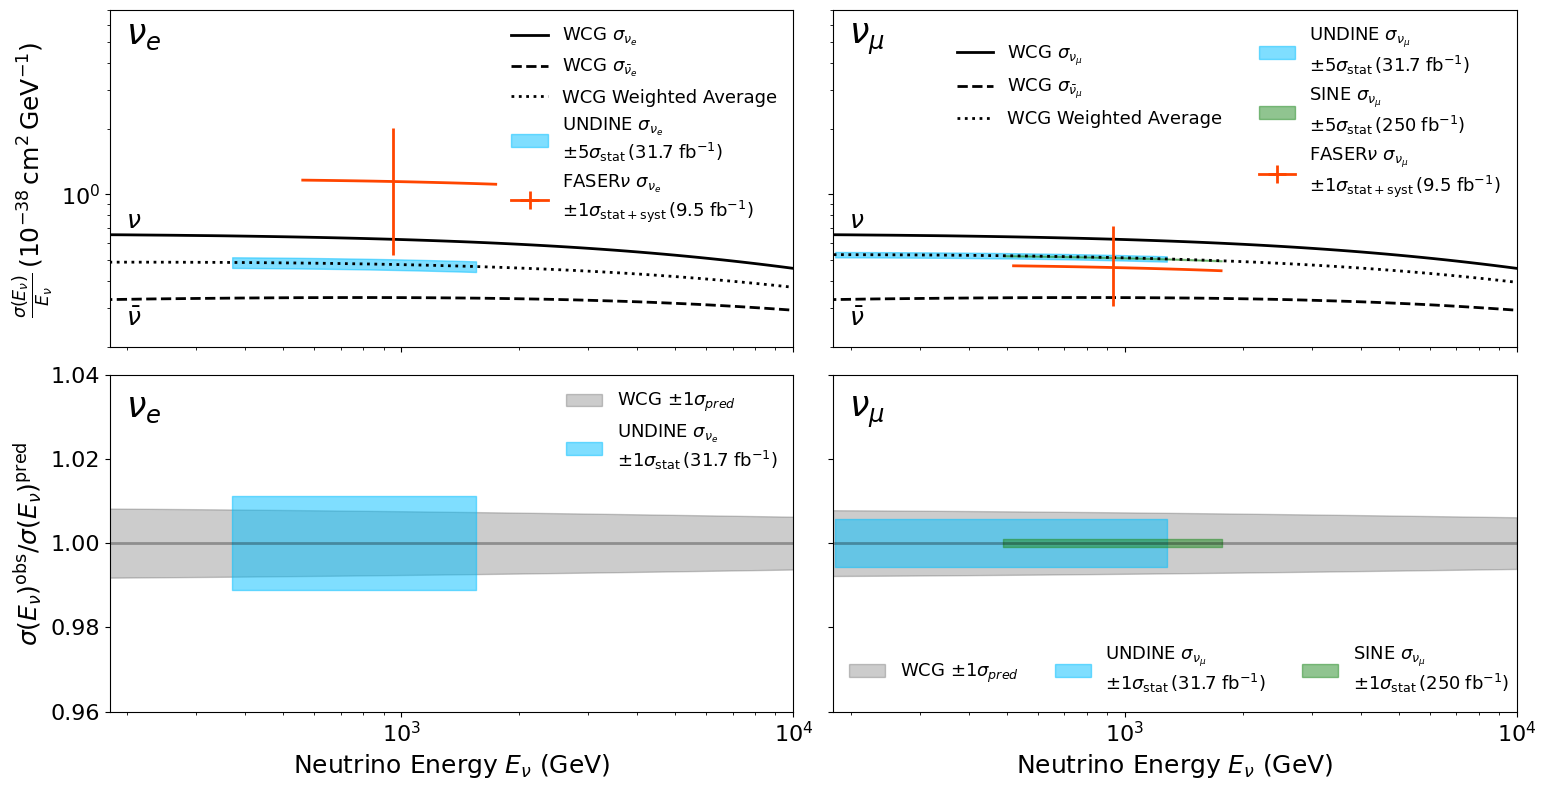

In [ ]:
exposure_factor = yearly_factor#1./150.
n_sigma_bottom=1
n_sigma_top=5

UNDINE_color="deepskyblue"
FASER_color="orangered"
SINE_color="forestgreen"

# flux ratios from arXiv:2403.12520
nu_nubar_nue = 1.03
nu_nubar_numu = 0.62
faser_nue_erange = np.linspace(560,1740,100)
faser_nue_alpha = [2.4,1.3,1.8] # cross section scaling
faser_nue_xs = [1.2,0.7,0.8]
faser_numu_erange = np.linspace(520,1760,100)
faser_numu_alpha = [0.9,0.3,0.5] # cross section scaling
faser_numu_xs = [0.5,0.2,0.2]
faser_numu_avg_xsec = [1./(1+nu_nubar_numu)*(DIS_xs[(14,"CC")].TotalCrossSection(numu,e) + nu_nubar_numu*DIS_xs[(-14,"CC")].TotalCrossSection(numubar,e)) for e in faser_numu_erange]
faser_nue_avg_xsec = [1./(1+nu_nubar_nue)*(DIS_xs[(12,"CC")].TotalCrossSection(nue,e) + nu_nubar_nue*DIS_xs[(-12,"CC")].TotalCrossSection(nuebar,e)) for e in faser_nue_erange]

numu_avg_xsec = [1./(1+nu_nubar_numu)*(DIS_xs[(14,"CC")].TotalCrossSection(numu,e) + nu_nubar_numu*DIS_xs[(-14,"CC")].TotalCrossSection(numubar,e)) for e in erange]
nue_avg_xsec = [1./(1+nu_nubar_nue)*(DIS_xs[(12,"CC")].TotalCrossSection(nue,e) + nu_nubar_nue*DIS_xs[(-12,"CC")].TotalCrossSection(nuebar,e)) for e in erange]

fig,ax = plt.subplots(2,2,figsize=(16,8),sharex="col",sharey="row")
fig.subplots_adjust(hspace=0.0,wspace=0.0)

SINE_numu_n = exposure_factor*(total_rates["SINE_CMS_West",'CC','light',14] + total_rates["SINE_CMS_West",'CC','charm',14])
UNDINE_numu_n = exposure_factor*(total_rates["UNDINE_LHCb_North",'CC','light',14] + total_rates["UNDINE_LHCb_North",'CC','charm',14])
UNDINE_nue_n = exposure_factor*(total_rates["UNDINE_LHCb_North",'CC','light',12] + total_rates["UNDINE_LHCb_North",'CC','charm',12])

SINE_numu_stat_err = 1./np.sqrt(SINE_numu_n)
UNDINE_numu_stat_err = 1./np.sqrt(UNDINE_numu_n)
UNDINE_nue_stat_err = 1./np.sqrt(UNDINE_nue_n)


ax[0,0].plot(erange,DIS_xs_range[(14,"CC")]/erange/1e-38,color="black",ls="-",label=r"WCG $\sigma_{\nu_e}$")
ax[0,0].plot(erange,DIS_xs_range[(-14,"CC")]/erange/1e-38,color="black",ls="--",label=r"WCG $\sigma_{\bar{\nu}_e}$")
ax[0,1].plot(erange,DIS_xs_range[(14,"CC")]/erange/1e-38,color="black",ls="-",label=r"WCG $\sigma_{\nu_\mu}$")
ax[0,1].plot(erange,DIS_xs_range[(-14,"CC")]/erange/1e-38,color="black",ls="--",label=r"WCG $\sigma_{\bar{\nu}_\mu}$")
ax[0,1].plot(erange,numu_avg_xsec/erange/1e-38,color="black",ls=":",label="WCG Weighted Average")
ax[0,0].plot(erange,nue_avg_xsec/erange/1e-38,color="black",ls=":",label="WCG Weighted Average")

FASER_midpoint = int(len(faser_nue_erange)/3)
ax[0,0].plot(faser_nue_erange,
             #faser_nue_xs[0]*np.ones_like(faser_nue_erange),
             faser_nue_alpha[0]*np.array(faser_nue_avg_xsec)/faser_nue_erange/1e-38,
             color=FASER_color)
ax[0,0].errorbar(faser_nue_erange[FASER_midpoint],faser_nue_alpha[0]*faser_nue_avg_xsec[FASER_midpoint]/faser_nue_erange[FASER_midpoint]/1e-38,
                 xerr=0,yerr=[[(faser_nue_alpha[1])*faser_nue_avg_xsec[FASER_midpoint]/faser_nue_erange[FASER_midpoint]/1e-38],
                              [(faser_nue_alpha[2])*faser_nue_avg_xsec[FASER_midpoint]/faser_nue_erange[FASER_midpoint]/1e-38]],
                 color=FASER_color,capsize=0,label=r"FASER$\nu$ $\sigma_{\nu_e}$"+"\n"+r"$\pm 1 \sigma_{\rm stat+syst}\,(9.5\;{\rm fb}^{-1})$")
# ax[0,0].fill_between(faser_nue_erange,
#                      #(faser_nue_xs[0]-faser_nue_xs[1])*np.ones_like(faser_nue_erange),
#                      (faser_nue_alpha[0]-faser_nue_alpha[1])*np.array(faser_nue_avg_xsec)/faser_nue_erange/1e-38,
#                      #(faser_nue_xs[2]+faser_nue_xs[0])*np.ones_like(faser_nue_erange),
#                      (faser_nue_alpha[0]+faser_nue_alpha[2])*np.array(faser_nue_avg_xsec)/faser_nue_erange/1e-38,
#                      color=FASER_color,alpha=0.2)
ax[0,1].plot(faser_numu_erange,
             #faser_numu_xs[0]*np.ones_like(faser_numu_erange),
             faser_numu_alpha[0]*np.array(faser_numu_avg_xsec)/faser_numu_erange/1e-38,
             color=FASER_color)
ax[0,1].errorbar(faser_numu_erange[FASER_midpoint],faser_numu_alpha[0]*faser_numu_avg_xsec[FASER_midpoint]/faser_numu_erange[FASER_midpoint]/1e-38,
                 xerr=0,yerr=[[(faser_numu_alpha[1])*faser_numu_avg_xsec[FASER_midpoint]/faser_numu_erange[FASER_midpoint]/1e-38],
                              [(faser_numu_alpha[2])*faser_numu_avg_xsec[FASER_midpoint]/faser_numu_erange[FASER_midpoint]/1e-38]],
                 color=FASER_color,capsize=0,label=r"FASER$\nu$ $\sigma_{\nu_\mu}$"+"\n"+r"$\pm 1 \sigma_{\rm stat+syst}\,(9.5\;{\rm fb}^{-1})$")
# ax[0,1].fill_between(faser_numu_erange,
#                      #(faser_numu_xs[0]-faser_nue_xs[1])*np.ones_like(faser_numu_erange),
#                      (faser_numu_alpha[0]-faser_numu_alpha[1])*np.array(faser_numu_avg_xsec)/faser_numu_erange/1e-38,
#                      #(faser_nue_xs[2]+faser_nue_xs[0])*np.ones_like(faser_nue_erange),
#                      (faser_numu_alpha[0]+faser_numu_alpha[2])*np.array(faser_numu_avg_xsec)/faser_numu_erange/1e-38,
#                      color=FASER_color,alpha=0.2)


UNDINE_numu_Erange_arr = np.linspace(*UNDINE_numu_Erange,100)
UNDINE_numu_avg_xsec = [1./(1+nu_nubar_numu)*(DIS_xs[(14,"CC")].TotalCrossSection(numu,e) + nu_nubar_numu*DIS_xs[(-14,"CC")].TotalCrossSection(numubar,e)) for e in UNDINE_numu_Erange_arr]
#ax[0].plot(UNDINE_numu_Erange_arr,UNDINE_numu_avg_xsec/UNDINE_numu_Erange_arr/1e-38,color="dodgerblue")
ax[0,1].fill_between(UNDINE_numu_Erange_arr,
                   (1-n_sigma_top*UNDINE_numu_stat_err)*(UNDINE_numu_avg_xsec/UNDINE_numu_Erange_arr/1e-38),
                   (1+n_sigma_top*UNDINE_numu_stat_err)*(UNDINE_numu_avg_xsec/UNDINE_numu_Erange_arr/1e-38),
                   color=UNDINE_color,alpha=0.5,
                     label=r"UNDINE $\sigma_{\nu_\mu}$"+"\n"+r"$\pm %d\sigma_{\rm stat}\,(%1.1f\;{\rm fb}^{-1})$"%(n_sigma_top,UNDINE_luminosity_factor*3000*exposure_factor))

UNDINE_nue_Erange_arr = np.linspace(*UNDINE_nue_Erange,100)
UNDINE_nue_avg_xsec = [1./(1+nu_nubar_nue)*(DIS_xs[(12,"CC")].TotalCrossSection(nue,e) + nu_nubar_nue*DIS_xs[(-12,"CC")].TotalCrossSection(nuebar,e)) for e in UNDINE_nue_Erange_arr]
#ax[0].plot(UNDINE_nue_Erange_arr,UNDINE_nue_avg_xsec/UNDINE_nue_Erange_arr/1e-38,color="dodgerblue")
ax[0,0].fill_between(UNDINE_nue_Erange_arr,
                   (1-n_sigma_top*UNDINE_nue_stat_err)*(UNDINE_nue_avg_xsec/UNDINE_nue_Erange_arr/1e-38),
                   (1+n_sigma_top*UNDINE_nue_stat_err)*(UNDINE_nue_avg_xsec/UNDINE_nue_Erange_arr/1e-38),
                   color=UNDINE_color,alpha=0.5,
                     label=r"UNDINE $\sigma_{\nu_e}$"+"\n"+r"$\pm %d\sigma_{\rm stat}\,(%1.1f\;{\rm fb}^{-1})$"%(n_sigma_top,UNDINE_luminosity_factor*3000*exposure_factor))

SINE_numu_Erange_arr = np.linspace(*SINE_numu_Erange,100)
SINE_numu_avg_xsec = [1./(1+nu_nubar_numu)*(DIS_xs[(14,"CC")].TotalCrossSection(numu,e) + nu_nubar_numu*DIS_xs[(-14,"CC")].TotalCrossSection(numubar,e)) for e in SINE_numu_Erange_arr]
#ax[0].plot(SINE_numu_Erange_arr,SINE_numu_avg_xsec/SINE_numu_Erange_arr/1e-38,color="orangered")
ax[0,1].fill_between(SINE_numu_Erange_arr,
                   (1-n_sigma_top*SINE_numu_stat_err)*(SINE_numu_avg_xsec/SINE_numu_Erange_arr/1e-38),
                   (1+n_sigma_top*SINE_numu_stat_err)*(SINE_numu_avg_xsec/SINE_numu_Erange_arr/1e-38),
                   color=SINE_color,alpha=0.5,
                     label=r"SINE $\sigma_{\nu_\mu}$"+"\n"+r"$\pm %d\sigma_{\rm stat}\,(%1.0f\;{\rm fb}^{-1})$"%(n_sigma_top,3000*exposure_factor))


# ratio plot

ax[1,0].plot(erange,np.ones_like(erange),alpha=0.3,color="black")
ax[1,0].fill_between(erange,
                   1-(1./(1+nu_nubar_nue)*(DIS_xs_unc[(12,"CC")](erange) + nu_nubar_nue*DIS_xs_unc[(-12,"CC")](erange))/100.),
                   1+(1./(1+nu_nubar_nue)*(DIS_xs_unc[(12,"CC")](erange) + nu_nubar_nue*DIS_xs_unc[(-12,"CC")](erange))/100.),
                   color="black",alpha=0.2,label="WCG $\pm 1 \sigma_{pred}$")

ax[1,1].plot(erange,np.ones_like(erange),alpha=0.3,color="black")
ax[1,1].fill_between(erange,
                   1-(1./(1+nu_nubar_numu)*(DIS_xs_unc[(14,"CC")](erange) + nu_nubar_numu*DIS_xs_unc[(-14,"CC")](erange))/100.),
                   1+(1./(1+nu_nubar_numu)*(DIS_xs_unc[(14,"CC")](erange) + nu_nubar_numu*DIS_xs_unc[(-14,"CC")](erange))/100.),
                   color="black",alpha=0.2,label="WCG $\pm 1 \sigma_{pred}$")

# ax[1,0].plot(faser_nue_erange,
#            faser_nue_alpha[0]*np.ones_like(faser_nue_erange),
#            color=FASER_color,label=r"FASER $\sigma_{\nu_e}$")
# ax[1,0].fill_between(faser_nue_erange,
#                    (faser_nue_alpha[0]-faser_nue_alpha[1])*np.ones_like(faser_nue_erange),
#                    (faser_nue_alpha[0]+faser_nue_alpha[2])*np.ones_like(faser_nue_erange),
#                    color=FASER_color,alpha=0.2)
# ax[1,1].plot(faser_numu_erange,
#            faser_numu_alpha[0]*np.ones_like(faser_numu_erange),
#            color=FASER_color,label=r"FASER $\sigma_{\nu_\mu}$")
# ax[1,1].fill_between(faser_numu_erange,
#                    (faser_numu_alpha[0]-faser_numu_alpha[1])*np.ones_like(faser_numu_erange),
#                    (faser_numu_alpha[0]+faser_numu_alpha[2])*np.ones_like(faser_numu_erange),
#                    color=FASER_color,alpha=0.2)


ax[1,1].fill_between(UNDINE_numu_Erange_arr,
                   (1-n_sigma_bottom*UNDINE_numu_stat_err),
                   (1+n_sigma_bottom*UNDINE_numu_stat_err),
                   color=UNDINE_color,alpha=0.5,
                    label=r"UNDINE $\sigma_{\nu_\mu}$"+"\n"+r"$\pm %d\sigma_{\rm stat}\,(%1.1f\;{\rm fb}^{-1})$"%(n_sigma_bottom,UNDINE_luminosity_factor*3000*exposure_factor))
ax[1,0].fill_between(UNDINE_nue_Erange_arr,
                   (1-n_sigma_bottom*UNDINE_nue_stat_err),
                   (1+n_sigma_bottom*UNDINE_nue_stat_err),
                   color=UNDINE_color,alpha=0.5,
                     label=r"UNDINE $\sigma_{\nu_e}$"+"\n"+r"$\pm %d\sigma_{\rm stat}\,(%1.1f\;{\rm fb}^{-1})$"%(n_sigma_bottom,UNDINE_luminosity_factor*3000*exposure_factor))
ax[1,1].fill_between(SINE_numu_Erange_arr,
                   (1-n_sigma_bottom*SINE_numu_stat_err),
                   (1+n_sigma_bottom*SINE_numu_stat_err),
                   color=SINE_color,alpha=0.5,
                     label=r"SINE $\sigma_{\nu_\mu}$"+"\n"+r"$\pm %d\sigma_{\rm stat}\,(%1.0f\;{\rm fb}^{-1})$"%(n_sigma_bottom,3000*exposure_factor))

emin=1.8e2
sigmax=7
ax[0,0].text(1.1*emin,0.7*sigmax,r"$\nu_e$",fontsize=25)
ax[1,0].text(1.1*emin,1.03,r"$\nu_e$",fontsize=25)
ax[0,0].text(1.1*emin,0.7,r"$\nu$",fontsize=18)
ax[0,0].text(1.1*emin,0.25,r"$\bar{\nu}$",fontsize=18)
ax[0,1].text(1.1*emin,0.7*sigmax,r"$\nu_\mu$",fontsize=25)
ax[1,1].text(1.1*emin,1.03,r"$\nu_\mu$",fontsize=25)
ax[0,1].text(1.1*emin,0.7,r"$\nu$",fontsize=18)
ax[0,1].text(1.1*emin,0.25,r"$\bar{\nu}$",fontsize=18)

ax[0,0].legend(fontsize=13)
ax[0,1].legend(fontsize=13,ncol=2)
ax[1,0].legend(fontsize=13)
ax[1,1].legend(fontsize=13,ncol=3,loc="lower left")



ax[0,0].loglog()
ax[0,1].loglog()
ax[0,0].set_ylim(2e-1,sigmax)
ax[0,0].set_ylabel(r"$\frac{\sigma(E_\nu)}{E_\nu}\,(10^{-38}\,{\rm cm}^2\,{\rm GeV}^{-1})$ ")
ax[1,0].semilogx()
ax[1,1].semilogx()
ax[1,0].set_ylim(0.96,1.04)
ax[1,0].set_xlim(emin,erange[-1])
ax[1,1].set_xlim(emin,erange[-1])
ax[1,0].set_ylabel(r"$\sigma(E_\nu)^{\rm obs}/\sigma(E_\nu)^{\rm pred}$ ")
ax[1,0].set_xlabel(r"Neutrino Energy $E_\nu$ (GeV)")
ax[1,1].set_xlabel(r"Neutrino Energy $E_\nu$ (GeV)")
# ax[1,0].set_xticklabels(ax[1,0].get_xticklabels()[:-2])
# ax[1,0].set_yticks(ax[1,0].get_yticks()[:-1])

plt.tight_layout()
plt.savefig("Figures/SIREN/CrossSection.pdf",dpi=100)
plt.show()

# Strangeness Enhancement Sensitivity
Following https://arxiv.org/abs/2309.10417

We want to compute the Fisher matrix of the log likelihood ratio test statistic in order to estimate the uncertainty from different hadron interaction models.

The likelihood here is given by

$$\mathcal{L}(\{k_d\}|\{\mu_d\}) = \prod_{d \in \{{\rm S_{tot},U_{tot},U_{\mu},U_e}\}} \frac{\mu_d^{k_d} e^{-\mu_d}}{k_d!}$$.

The prediction is given by 

$$
\mu_d = \sum_{p \in \{\pi,K,c\}} \frac{1}{N_p} 
\big[ 
G_0^{p,d} \big(1 - \sum_{i=1}^{N_p - 1} \lambda_i^p \big) 
+ \sum_{i=1}^{N_p-1} G_i^{p,d} \big( 1 + N_p \lambda_i^p - \sum_{j=1}^{N_p-1} \lambda_j^p \big)
\big],
$$

where $G_i^{p,d}$ is the prediction from parent meson $p$ in dataset $d$ for generator $i = \{{\rm EPOSLHC,SIBYLL,...}\}$, for example. The $\lambda_i^p$ are parameters that control the deviation from the nominal prediction. The test statistic that we use to compute the Fisher matrix is

$$r \equiv \frac{\mathcal{L}(\{k_d\}|\{\mu_d(\{\lambda_i^\pi\})\},\{\lambda_i^K\})\},\{\lambda_i^c\})\}) }{\mathcal{L}(\{k_d\}|\{\mu_d(\{\lambda_i^\pi=0\})\},\{\lambda_i^K=0\})\},\{\lambda_i^c=0\})\})} $$

the fisher matrix is then given by

$$I_{(p,i),(p',j)} = -\frac{d^2 \log r}{d \lambda_i^p d \lambda_j^{p'}}  \\
= ... \\
= \sum_d \frac{k_d}{[\mu_d(\{\lambda_i^p\})]^2} \frac{d}{d\lambda_i^p}\mu_d(\{\lambda_i^p\}) \frac{d}{d\lambda_j^{p'}}\mu_d(\{\lambda_j^{p'}\})
$$

After some math, we can show

$$\frac{d}{d\lambda_i^p} \mu_d(\{\lambda_i^p\}) = G_i^{p,d} - \frac{1}{N_p} \sum_{j=0}^{N_p-1} G_j^{p,d}$$

so 

$$I_{(p,i),(p',j)} =\sum_d \frac{k_d}{[\mu_d(\{\lambda_i^p\})]^2}
[G_i^{p,d} - \frac{1}{N_p} \sum_{k=0}^{N_p-1} G_k^{p,d}]
[G_j^{p',d} - \frac{1}{N_{p'}} \sum_{k=0}^{N_{p'}-1} G_k^{p',d}]
$$

The Cramer-Rao bound then states

$$ C_{(p,i),(p',j)} \geq I_{(p,i),(p',j)} $$

In [10]:
G = {}
exposure_factor = 1#yearly_factor
for dataset,dname in zip([SINE_rate_nominal, UNDINE_rate_nominal, UNDINE_muons_edist_nominal, UNDINE_electrons_edist_nominal],
                         ["SINE_rate", "UNDINE_rate", "UNDINE_muons_edist", "UNDINE_electrons_edist"]):
    if "edist" in dname:
        if "muons" in dname:
            bins = range(len(UNDINE_muon_ebins)-1)
        if "electrons" in dname:
            bins = range(len(UNDINE_electron_ebins)-1)
    else:
        bins = range(1)
    for ibin in bins:
        dataset_string = "%s_bin%d"%(dname,ibin)
        G[dataset_string] = {}
        for parent in ["Pions","Kaons","Charm"]:
            G[dataset_string][parent]= {}
            gen_idx = 0 if parent in ["Pions","Kaons"] else 1
            for generators in zip(light_generators,charm_generators):
                if "edist" in dname: G[dataset_string][parent][generators[gen_idx]] = dataset[generators][parent][ibin]
                else: G[dataset_string][parent][generators[gen_idx]] = dataset[generators][parent]
                G[dataset_string][parent][generators[gen_idx]]*=exposure_factor
#G

In [11]:
light_generator_base="EPOSLHC"
charm_generator_base="BKSS"


def f_fs(f_s,parent):
    if parent=="Pions": 
        return (1 - f_s)
    elif parent=="Kaons":
        return (1 + 6.6*f_s)
    return 1

def mu_parent(dataset_name,
              parent,
              parent_lambdas,
              light_generator_base="SIBYLL",
              charm_generator_base="SIBYLL"):
    Np = len(G[dataset_name][parent].keys())
    lambda_bar = np.sum(parent_lambdas)
    generators = list(G[dataset_name][parent].keys())
    if parent in ["Pions","Kaons"]:
        generators.remove(light_generator_base)
        mu_p = G[dataset_name][parent][light_generator_base] * (1 - lambda_bar)
    else:
        generators.remove(charm_generator_base)
        mu_p = G[dataset_name][parent][charm_generator_base] * (1 - lambda_bar)
    for generator,lam in zip(generators,parent_lambdas):
        mu_p += G[dataset_name][parent][generator] * (1 + Np*lam - lambda_bar)
    mu_p /= Np
    return mu_p
    
def mu(dataset_name,
       lambdas,
       light_generator_base="SIBYLL",
       charm_generator_base="SIBYLL",
       f_s = 0):
    assert(lambdas.shape==(3,len(G[dataset_name]["Pions"])-1))
    mu = 0
    for ip,parent in enumerate(G[dataset_name].keys()):
        if parent=="All": continue
        mu_p = mu_parent(dataset_name,parent,lambdas[ip],
                         light_generator_base=light_generator_base,
                         charm_generator_base=charm_generator_base)
        mu_p *= f_fs(f_s,parent)
        mu += mu_p
    return mu

def nllh(lambdas,f_s,observation="null"):
    lambdas = lambdas.reshape((3,4))
    LLH = 0
    for dataset_name in G.keys():
        mu_d = mu(dataset_name,lambdas=lambdas,f_s=f_s)
        if observation=="null": k_d = mu(dataset_name,lambdas=np.zeros_like(lambdas),f_s=0)
        elif observation=="alt": k_d = mu(dataset_name,lambdas=np.zeros_like(lambdas),f_s=f_s)
        LLH += k_d*np.log(mu_d) - mu_d - gammaln(k_d)
    #print(lambdas,LLH)
    return -LLH

def delta_llh(lambdas,f_s,observation="null"):
    lambdas = lambdas.reshape((3,4))
    delta_LLH = 0
    #print(lambdas)
    for dataset_name in G.keys():
        mu_d_null = mu(dataset_name,lambdas=np.zeros_like(lambdas),f_s=0)
        mu_d_alt = mu(dataset_name,lambdas=lambdas,f_s=f_s)
        if observation=="null": k_d = mu_d_null
        elif observation=="alt": k_d = mu(dataset_name,lambdas=np.zeros_like(lambdas),f_s=f_s)
        #print(dataset_name,mu_d_alt,mu_d_null)
        delta_LLH += k_d * np.log(mu_d_alt/mu_d_null) - (mu_d_alt - mu_d_null)
    return -2 * delta_LLH

def profile_llh(f_s,observation="null"):
    
    args = (f_s,observation)
    cons = ({'type': 'ineq', 'fun': lambda x : 1 - sum(x[0:4])},
            {'type': 'ineq', 'fun': lambda x : 1 - sum(x[4:8])},
            {'type': 'ineq', 'fun': lambda x : 1 - sum(x[8:])})
    for dataset_name in G.keys():
        for ip,parent in enumerate(G[dataset_name].keys()):
            i_lambda_start = 4*ip
            i_lambda_end = 4*(ip+1)
            generators = list(G[dataset_name][parent].keys())
            if parent in ["Pions","Kaons"]:
                generators.remove(light_generator_base)
                X = G[dataset_name][parent][light_generator_base]
            else:
                generators.remove(charm_generator_base)
                X = G[dataset_name][parent][charm_generator_base]
            Y = sum([G[dataset_name][parent][g] for g in generators])
            lambda_sum_min = -X/(Y - (X+Y)/len(generators))
            #print(dataset_name,parent,f_s,lambda_sum_min)
            if not np.isnan(lambda_sum_min):
                cons += ({'type': 'ineq', 'fun': lambda x : -sum(x[i_lambda_start:i_lambda_end]) + lambda_sum_min},)
            
    x0 = np.zeros(3*4)
    bounds = ((-1,1) for _ in range(len(x0)))
    res = minimize(nllh,x0,args,
                   bounds=bounds,
                   constraints=cons,
                   method="SLSQP",
                   options={"maxiter":1000})
    # while np.all(res.x==np.zeros_like(res.x)):
    #     x0 = np.array(2*np.random.rand(12)-1,dtype=float) # between -1 and 1
    #     print(x0)
    #     res = minimize(nllh,x0,args,
    #                    bounds=bounds,
    #                    constraints=cons,
    #                    #method="COBYLA",
    #                    options={"maxiter":1000})
        
    
    #print(f_s)
    #print(res.fun)
    #print(np.all(res.x==np.zeros_like(res.x)))
    return res.fun
    
f_s_range = np.logspace(-5,-1,50)
llh_null = profile_llh(0)
TS_range = [-2*(-profile_llh(f_s) + llh_null) for f_s in f_s_range]


/tmp/ipykernel_2098424/3651673990.py:89: RuntimeWarning: invalid value encountered in scalar divide
  lambda_sum_min = -X/(Y - (X+Y)/len(generators))
/tmp/ipykernel_2098424/3651673990.py:54: RuntimeWarning: divide by zero encountered in log
  LLH += k_d*np.log(mu_d) - mu_d - gammaln(k_d)
/tmp/ipykernel_2098424/3651673990.py:54: RuntimeWarning: invalid value encountered in log
  LLH += k_d*np.log(mu_d) - mu_d - gammaln(k_d)


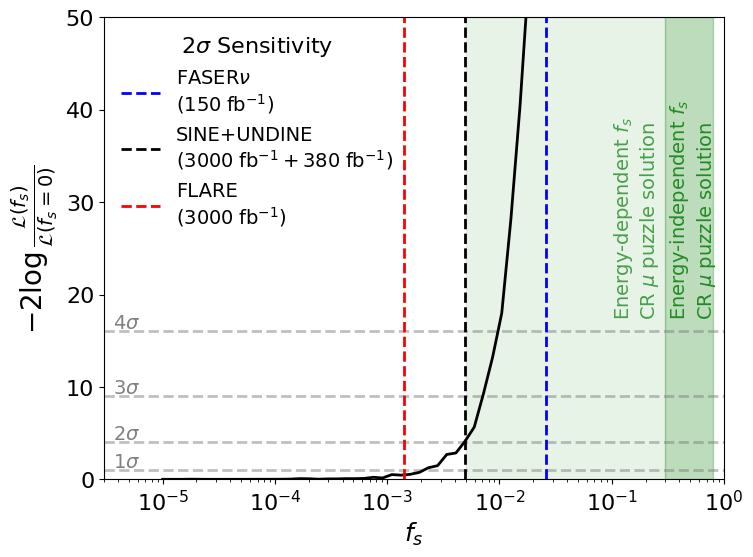

In [52]:
xmin=3e-6#f_s_range[0]
xmax = 1
TS_range = np.array(TS_range)

plt.ylim(0,50)
for sigma in [1,2,3,4]:
    val = chi2.isf(2*norm.sf(sigma),1)
    plt.plot([xmin,xmax],[val,val],color="grey",ls="--",alpha=0.5)
    plt.text(1.2*xmin,val+0.3,r"$%d\sigma$"%sigma,fontsize=14,color="grey")

# plot other constraints

# preferred region from cosmic muon puzzle
plt.gca().axvspan(0.3,0.8,color="forestgreen",alpha=0.3)
plt.text(0.32,18,r"Energy-independent $f_s$"+"\n"+r"CR $\mu$ puzzle solution",rotation=90,fontsize=14,color="forestgreen")
plt.gca().axvspan(0.005,0.3,color="forestgreen",alpha=0.1)
plt.text(0.1,18,r"Energy-dependent $f_s$"+"\n"+r"CR $\mu$ puzzle solution",rotation=90,fontsize=14,color="forestgreen",alpha=0.8)

# FASERnu constraint (2 sigma)
plt.gca().axvline(0.013*2,color="blue",ls="--",label=r"FASER$\nu$"+"\n"+r"($150\;{\rm fb}^{-1}$)")

# our constraint (2 sigma)
TS_interp = interp1d(f_s_range[TS_range<100],TS_range[TS_range<100],fill_value="extrapolate")
f_s_range_interp = np.logspace(np.log10(f_s_range[0]),np.log10(f_s_range[-1]),50)
TS_range_interp = TS_interp(f_s_range_interp)
plt.plot(f_s_range,TS_interp(f_s_range),color="black")
critical_val_2sigma = chi2.isf(2*norm.sf(2),1) # 2 sigma value
f_s_2sigma = f_s_range_interp[np.argmin(np.abs(TS_range_interp-critical_val_2sigma))]
plt.gca().axvline(f_s_2sigma,color="black",ls="--",label="SINE+UNDINE\n"+r"($%d\;{\rm fb}^{-1}+%d\;{\rm fb}^{-1}$)"%(3000*exposure_factor,3000*exposure_factor*UNDINE_luminosity_factor))


# FLARE constraint (2 sigma)
plt.gca().axvline(0.0014,color="red",ls="--",label=r"FLARE"+"\n"+r"($3000\;{\rm fb}^{-1}$)")


plt.ylabel(r"$-2\log \frac{\mathcal{L}(f_s)}{ \mathcal{L}(f_s=0)}$",fontsize=20)
plt.xlabel(r"$f_s$")
plt.semilogx()
plt.legend(title=r"$2\sigma$ Sensitivity",title_fontsize=16,fontsize=14)
plt.xlim(xmin,xmax)
plt.savefig("Figures/SIREN/StrangenessEnhancement_sensitivity.pdf",dpi=100)
plt.show()

(13, 13)


/tmp/ipykernel_2098424/3412812986.py:25: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  pion_idx = np.where(list(G[dataset_name].keys())=="Pions")
/tmp/ipykernel_2098424/3412812986.py:26: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  kaon_idx = np.where(list(G[dataset_name].keys())=="Kaons")
/tmp/ipykernel_2098424/3412812986.py:46: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  pion_i

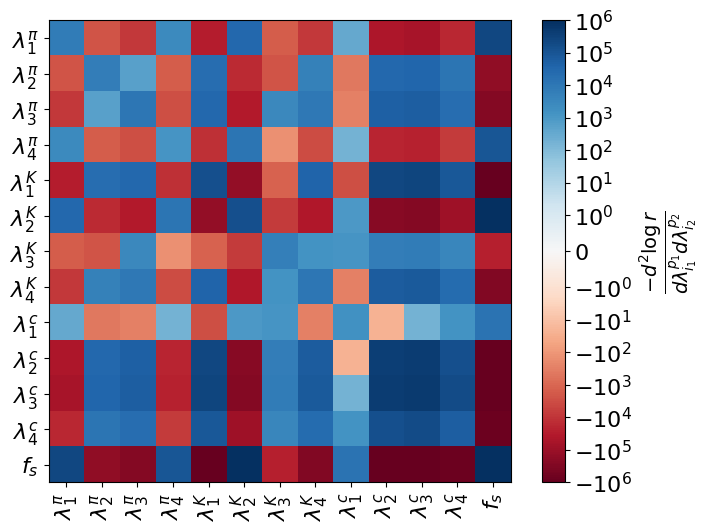

[[0.01283447]]


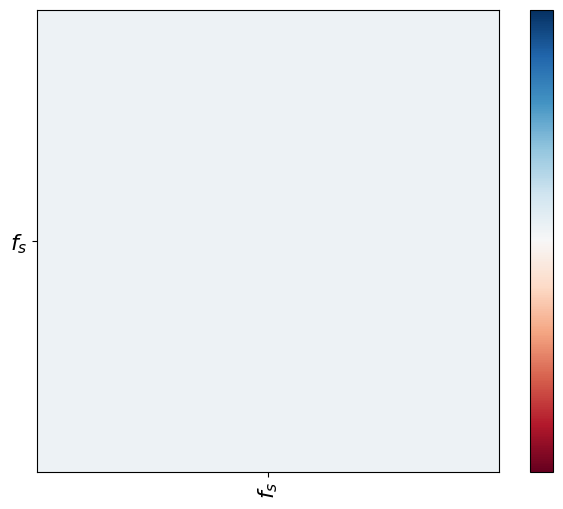

In [53]:


def fisher_matrix_element(lambdas,
                          f_s=0,
                          parent_1=None,generator_1=None,
                          parent_2=None,generator_2=None,
                          dataset_name_1=None,
                          dataset_name_2=None,
                          f_s_1=False,
                          f_s_2=False):
    assert(lambdas.shape==(3,len(G["SINE_rate_bin0"]["Pions"])-1))
    element = 0
    if parent_1 and generator_1 and parent_2 and generator_2:
        for dataset_name in G.keys():
            k = mu(dataset_name,np.zeros_like(lambdas))
            _mu = mu(dataset_name,lambdas)
            prefactor = k / (_mu**2)
            diff1 = G[dataset_name][parent_1][generator_1] - np.average(list(G[dataset_name][parent_1].values()))
            diff2 = G[dataset_name][parent_2][generator_2] - np.average(list(G[dataset_name][parent_2].values()))
            element += prefactor*diff1*diff2
        return element
    elif f_s_1 and parent_2 and generator_2:
        for dataset_name in G.keys():
            k = mu(dataset_name,np.zeros_like(lambdas))
            _mu = mu(dataset_name,lambdas)
            diff2 = G[dataset_name][parent_2][generator_2] - np.average(list(G[dataset_name][parent_2].values()))
            pion_idx = np.where(list(G[dataset_name].keys())=="Pions")
            kaon_idx = np.where(list(G[dataset_name].keys())=="Kaons")
            term_left = k/(_mu**2) * f_fs(f_s,parent_2)*(6.6*mu_parent(dataset_name,"Kaons",lambdas[kaon_idx]) - mu_parent(dataset_name,"Pions",lambdas[pion_idx]))
            term_right = (k/_mu - 1) * (6.6*(parent_2=="Kaons") - (parent_2=="Pions"))
            element += diff2 * (term_left - term_right)
        return element
    elif f_s_2 and parent_1 and generator_1:
        for dataset_name in G.keys():
            k = mu(dataset_name,np.zeros_like(lambdas))
            _mu = mu(dataset_name,lambdas)
            diff1 = G[dataset_name][parent_1][generator_1] - np.average(list(G[dataset_name][parent_1].values()))
            pion_idx = np.where(list(G[dataset_name].keys())=="Pions")
            kaon_idx = np.where(list(G[dataset_name].keys())=="Kaons")
            term_left = k/(_mu**2) * f_fs(f_s,parent_1)*(6.6*mu_parent(dataset_name,"Kaons",lambdas[kaon_idx]) - mu_parent(dataset_name,"Pions",lambdas[pion_idx]))
            term_right = (k/_mu - 1) * (6.6*(parent_1=="Kaons") - (parent_1=="Pions"))
            element += diff1 * (term_left - term_right)
        return element
    elif f_s_1 and f_s_2:
        for dataset_name in G.keys():
            k = mu(dataset_name,np.zeros_like(lambdas))
            prefactor = k / (mu(dataset_name,lambdas)**2)
            pion_idx = np.where(list(G[dataset_name].keys())=="Pions")
            kaon_idx = np.where(list(G[dataset_name].keys())=="Kaons")
            element += prefactor * (6.6*mu_parent(dataset_name,"Kaons",lambdas[kaon_idx]) - mu_parent(dataset_name,"Pions",lambdas[pion_idx]))**2
        return element
    elif parent_1 and generator_1 and dataset_name_2:
        k = mu(dataset_name_2,np.zeros_like(lambdas))
        prefactor = k / (mu(dataset_name_2,lambdas)**2)
        diff1 = G[dataset_name_2][parent_1][generator_1] - np.average(list(G[dataset_name_2][parent_1].values()))
        return prefactor*diff1
    elif parent_2 and generator_2 and dataset_name_1:
        k = mu(dataset_name_1,np.zeros_like(lambdas))
        prefactor = k / (mu(dataset_name_1,lambdas)**2)
        diff2 = G[dataset_name_1][parent_2][generator_2] - np.average(list(G[dataset_name_1][parent_2].values()))
        return prefactor*diff2
    elif dataset_name_1 and dataset_name_2:
        k = mu(dataset_name_1,np.zeros_like(lambdas))
        prefactor = k / (mu(dataset_name_1,lambdas)**2)
        return prefactor*(dataset_name_1==dataset_name_2)
    else:
        print("Invalide fisher matrix element request")
        return -np.inf

def condition_number_thresholding(I, threshold=1e-5):
    # Step 1: Eigenvalue Decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(I)

    # Step 2: Adjust Small Eigenvalues
    # For each eigenvalue, if it's smaller than threshold, set it to threshold
    regularized_eigenvalues = np.maximum(eigenvalues, threshold)

    # Step 3: Reconstruct the Regularized Matrix
    # Rebuild the Fisher matrix using the regularized eigenvalues
    regularized_I = (eigenvectors @ np.diag(regularized_eigenvalues) @ eigenvectors.T)

    return regularized_I

def pca_fisher_reduction(I, variance_threshold=0.999999):
    # Step 1: Eigenvalue Decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(I)

    # Step 2: Sort eigenvalues and eigenvectors in descending order of eigenvalue magnitude
    indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[indices]
    sorted_eigenvectors = eigenvectors[:, indices]

    # Step 3: Determine number of components to satisfy variance threshold
    total_variance = np.sum(sorted_eigenvalues)
    variance_explained = np.cumsum(sorted_eigenvalues) / total_variance
    num_components = np.searchsorted(variance_explained, variance_threshold) + 1

    # Step 4: Reconstruct Reduced Fisher Matrix
    V_selected = sorted_eigenvectors[:, :num_components]
    Lambda_selected = np.diag(sorted_eigenvalues[:num_components])
    
    I_reduced = V_selected @ Lambda_selected @ V_selected.T

    return I_reduced

def profile_information_matrix(I, param_index):
    """
    Profiles over a single parameter in the Fisher information matrix.

    Args:
    - I: 2D NumPy array representing the Fisher information matrix.
    - param_index: int representing the index of the parameter to profile out.

    Returns:
    - I_profiled: 2D NumPy array representing the profiled information matrix.
    """
    # Remove the nth row and column to form the reduced information matrix
    I_reduced = np.delete(np.delete(I, param_index, axis=0), param_index, axis=1)
    
    # Extract the nth column, with the nth entry removed, to form the vector m
    m = np.delete(I[:, param_index], param_index)

    # The diagonal term for normalization
    I_nn = I[param_index, param_index]
    
    # Compute the outer product of m with itself, and normalize by I_nn
    m_outer = np.outer(m, m) / I_nn if I_nn != 0 else np.zeros_like(I_reduced)

    # Profiled information matrix
    I_profiled = I_reduced - m_outer

    return I_profiled
        
    

# Construct fisher matrix
I_len = len(G["SINE_rate_bin0"])*(len(G["SINE_rate_bin0"]["Pions"])-1)
I_len += 1 # if using f_s
# I_len += len(G) # if using dataset predictions in fisher matrix
I = np.zeros((I_len,I_len))
print(I.shape)
axis_labels = []

for ip,(parent_1,parent_label) in enumerate(zip(["Pions","Kaons","Charm"],
                                                ["\pi","K","c"])):
    generators_1 = list(G["SINE_rate_bin0"][parent_1].keys())
    if parent_1 in ["Pions","Kaons"]: generators_1.remove(light_generator_base)
    else: generators_1.remove(charm_generator_base)
    for ig,generator_1 in enumerate(generators_1):
        i = ip*len(generators_1) + ig
        axis_labels.append(r"$\lambda^%s_%d$"%(parent_label,ig+1))
        for jp,parent_2 in enumerate(["Pions","Kaons","Charm"]):
            generators_2 = list(G["SINE_rate_bin0"][parent_2].keys())
            if parent_2 in ["Pions","Kaons"]: generators_2.remove(light_generator_base)
            else: generators_2.remove(charm_generator_base)
            for jg,generator_2 in enumerate(generators_2):
                j = jp*len(generators_2) + jg
                I[i,j] = fisher_matrix_element(lambdas=np.zeros((3,4)),
                                               parent_1=parent_1,
                                               generator_1=generator_1,
                                               parent_2=parent_2,
                                               generator_2=generator_2,
                                               )
                #print(i,j,parent_1,generator_1,parent_2,generator_2,I[i,j])

# f_s entries
i = len(G["SINE_rate_bin0"])*(len(G["SINE_rate_bin0"]["Pions"])-1)
axis_labels.append(r"$f_s$")
for jp,parent_2 in enumerate(["Pions","Kaons","Charm"]):
    generators_2 = list(G["SINE_rate_bin0"][parent_2].keys())
    if parent_2 in ["Pions","Kaons"]: generators_2.remove(light_generator_base)
    else: generators_2.remove(charm_generator_base)
    for jg,generator_2 in enumerate(generators_2):
        j = jp*len(generators_2) + jg
        I[i,j] = fisher_matrix_element(lambdas=np.zeros((3,4)),
                                       f_s_1 = True,
                                       parent_2=parent_2,
                                       generator_2=generator_2,
                                       )
        I[j,i] = I[i,j]
I[i,i] = fisher_matrix_element(lambdas=np.zeros((3,4)),
                               f_s_1 = True,
                               f_s_2 = True
                               )
                
# dataset entries
def get_number_after_bin(input_string):
    # Find the starting index of the substring "bin"
    bin_index = input_string.find("bin")
    
    if bin_index != -1:
        # The number starts right after the substring "bin"
        number_start_index = bin_index + len("bin")
        
        # Extract the substring from the number start index to the end of the string
        number_substring = input_string[number_start_index:]
        
        # Return the number as an integer
        return int(number_substring)
    else:
        return None

def dataset_label(dataset_name):
    if "SINE" in dataset_name:
        #axis_label = r"\mu^{\rm S\,tot}"
        axis_label = r"S^{tot}"
    else:
        if "muons" in dataset_name:
            #axis_label = r"\mu^{\rm U\,\mu}"
            axis_label = r"U^{\mu}"
        elif "electrons" in dataset_name:
            #axis_label = r"\mu^{\rm U\,e}"
            axis_label = r"U^{e}"
        else:
            #axis_label = r"\mu^{\rm U\,tot}"
            axis_label = r"U^{tot}"
    if "edist" in dataset_name:
        axis_label += "_{%d}"%get_number_after_bin(dataset_name)
    return r"${\rm %s}$"%axis_label
    
# for i_d,dataset_name_1 in enumerate(G.keys()):
#     i = len(G["SINE_rate_bin0"])*(len(G["SINE_rate_bin0"]["Pions"])-1) + i_d
#     axis_labels.append(dataset_label(dataset_name))
#     for jp,parent_2 in enumerate(["Pions","Kaons","Charm"]):
#         generators_2 = list(G["SINE_rate_bin0"][parent_2].keys())
#         if parent_2 in ["Pions","Kaons"]: generators_2.remove(light_generator_base)
#         else: generators_2.remove(charm_generator_base)
#         for jg,generator_2 in enumerate(generators_2):
#             j = jp*len(generators_2) + jg
#             I[i,j] = fisher_matrix_element(lambdas=np.zeros((3,4)),
#                                            dataset_name_1=dataset_name_1,
#                                            parent_2=parent_2,
#                                            generator_2=generator_2,
#                                            )
#             I[j,i] = I[i,j]
            
# for i_d,dataset_name_1 in enumerate(G.keys()):
#     i = len(G["SINE_rate_bin0"])*(len(G["SINE_rate_bin0"]["Pions"])-1) + i_d
#     for j_d,dataset_name_2 in enumerate(G.keys()):
#         j = len(G["SINE_rate_bin0"])*(len(G["SINE_rate_bin0"]["Pions"])-1) + j_d
#         I[i,j] = fisher_matrix_element(lambdas=np.zeros((3,4)),
#                                        dataset_name_1=dataset_name_1,
#                                        dataset_name_2=dataset_name_2,
#                                        )

I_lambdas = I[:12,:12]
axis_labels_lambdas = axis_labels[:12]
plt.figure()
plt.imshow(I,cmap="RdBu",norm=SymLogNorm(linthresh=1,vmin=-1e6,vmax=1e6))
c = plt.colorbar()
c.set_label(r"$\frac{-d^2 \log r}{d \lambda_{i_1}^{p_1} d \lambda_{i_2}^{p_2}}$",fontsize=20)
# Set the number of ticks to match the length of axis_labels
plt.xticks(ticks=range(len(axis_labels)), labels=axis_labels, rotation=90)
plt.yticks(ticks=range(len(axis_labels)), labels=axis_labels)
plt.savefig("Figures/SIREN/FisherMatrix.pdf",dpi=100)
plt.show()

I_red = profile_information_matrix(I,0)
axis_labels_red = axis_labels.copy()
del axis_labels_red[0]
while(len(I_red)>1):
    I_red = profile_information_matrix(I_red,0)
    del axis_labels_red[0]
print(I_red**-0.5)
plt.imshow(I_red,cmap="RdBu",norm=SymLogNorm(linthresh=1e-1))
plt.colorbar()
# Set the number of ticks to match the length of axis_labels
plt.xticks(ticks=range(len(axis_labels_red)), labels=axis_labels_red, rotation=90)
plt.yticks(ticks=range(len(axis_labels_red)), labels=axis_labels_red)
plt.show()

179040.25334820568


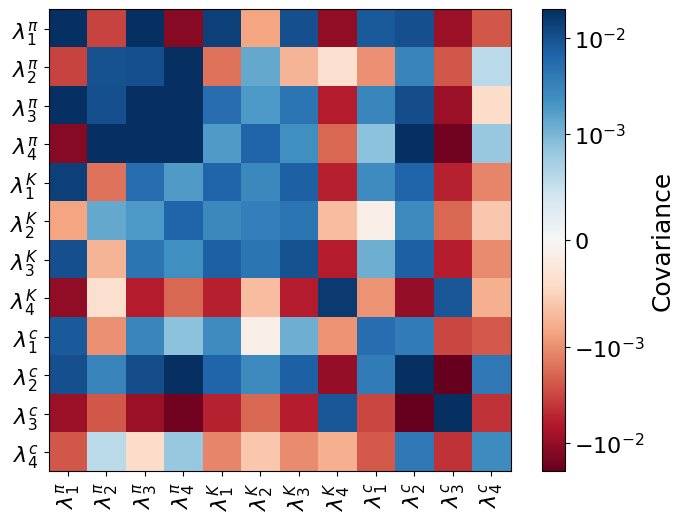

y1 [2.85046255e-04 2.85046255e-04 1.27084699e-03 1.66538284e-02
 8.20833126e-03 4.74655968e-03 3.31371017e-03 2.90331986e-03
 3.48479192e-03 7.60194549e-03 1.10698290e-01 2.44464275e-01
 1.17407737e-01 6.03237590e-02 3.63198124e-02 2.03158354e-02
 1.29124476e-02 9.20582532e-03 7.48089307e-03 6.90573229e-03
 7.15050135e-03 9.12919347e-03 1.79271604e-02 7.00106850e-02
 1.54781249e+00 1.54781249e+00]
y2 [2.22570247e+05 2.22570247e+05 1.16853900e+04 1.07413377e+02
 3.11282511e+02 6.33797030e+02 1.44542055e+03 3.10099287e+03
 1.34409037e+03 6.42084600e+02 1.26803234e+01 6.33131971e-01
 2.87975713e+00 1.46162167e+01 3.27454341e+01 1.15132906e+02
 2.04076259e+02 3.83089189e+02 4.01393380e+02 2.32993313e+02
 6.65385386e+02 8.44764887e+02 3.61574865e+02 2.91288304e+01
 7.00221931e-02 7.00221931e-02]
tot_err [0.01808638 0.01808638 0.01891525 0.03413004 0.02252224 0.01504757
 0.01621392 0.02629984 0.01669018 0.03787651 0.19078509 0.24737517
 0.12393695 0.08042322 0.05643558 0.05167983 0.03639359 

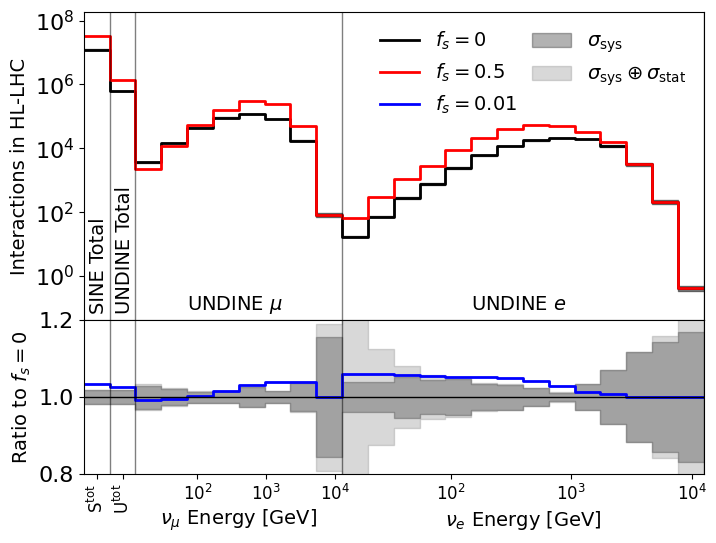

In [58]:
print(np.linalg.cond(I_lambdas))
C = np.linalg.inv(I_lambdas)
eigvals,eigvecs = np.linalg.eigh(C)
mu_baselines = {dataset_name:mu(dataset_name,np.zeros((3,4))) for dataset_name in G.keys()}
mu_baselines_fs = {f_s:{dataset_name:mu(dataset_name,np.zeros((3,4)),f_s=f_s) for dataset_name in G.keys()} for f_s in [0.5,1e-2]}
mu_variances = {dataset_name:0 for dataset_name in G.keys()}
for eigval,eigvec in zip(eigvals,eigvecs):
    # print(eigval)
    # print(eigvec)
    values = eigval*eigvec
    lambdas = values.reshape(3,4)#.T
    for dataset_name in G.keys():
        diff = mu(dataset_name,lambdas) - mu_baselines[dataset_name]
        mu_variances[dataset_name] += diff**2

plt.imshow(C,cmap="RdBu",norm=SymLogNorm(linthresh=0.001,vmin=-2e-2,vmax=2e-2))
c = plt.colorbar()
c.set_label("Covariance")
# Set the number of ticks to match the length of axis_labels
plt.xticks(ticks=range(len(axis_labels_lambdas)), labels=axis_labels_lambdas, rotation=90)
plt.yticks(ticks=range(len(axis_labels_lambdas)), labels=axis_labels_lambdas)
plt.savefig("Figures/SIREN/CovarianceMatrix.pdf",dpi=100)
plt.show()

fig,ax = plt.subplots(2,1,sharex=True,gridspec_kw={'height_ratios': [2, 1]})
fig.subplots_adjust(hspace=0.0)
y1 = np.array(list(mu_baselines.values()))
y1 = np.array([y1[0]] + list(y1) + [y1[-1]])
ymin1,ymax1 = 0.1*np.min(y1),15*np.max(y1)
ax[0].step(range(-1,len(mu_baselines)+1),y1,where="mid",color="black",label=r"$f_s=0$")
y1_fs = np.array(list(mu_baselines_fs[0.5].values()))
y1_fs = np.array([y1_fs[0]] + list(y1_fs) + [y1_fs[-1]])
ax[0].step(range(-1,len(mu_baselines)+1),y1_fs,where="mid",color="red",label=r"$f_s=0.5$")
y2 = np.sqrt(list(mu_variances.values()))
y2 = np.array([y2[0]] + list(y2) + [y2[-1]])
ymin2,ymax2 = 0.99*np.min(1 - y2/y1),1.01*np.max(1 + y2/y1)
ax[0].fill_between(range(-1,len(mu_baselines)+1),y1-y2,y1+y2,color="black",alpha=0.5,step="mid")
y2_fs = np.array(list(mu_baselines_fs[1e-2].values()))
y2_fs = np.array([y2_fs[0]] + list(y2_fs) + [y2_fs[-1]])
ymin2 = 0.8#min(0.99*np.min(y2_fs/y1),ymin2)
ymax2 = 1.2#max(1.01*np.max(y2_fs/y1),ymax2)
ax[1].step(range(-1,len(mu_baselines)+1),y2_fs/y1,where="mid",color="blue")
ax[0].step([],[],where="mid",color="blue",label=r"$f_s=%1.2f$"%1e-2)
ax[1].step(range(-1,len(mu_baselines)+1),np.ones_like(y2_fs),where="mid",color="black",lw=1)
ax[1].fill_between(range(-1,len(mu_variances)+1),1 - y2/y1,1 + y2/y1,color="black",alpha=0.3,step="mid")
ax[0].fill_between([],[],[],color="black",alpha=0.3,step="mid",label=r"$\sigma_{\rm sys}$")
tot_err = np.sqrt(y1 + (y2)**2)/y1
print("y1",(1/np.sqrt(y1)))
print("y2",y2)
print("tot_err",tot_err)
ax[1].fill_between(range(-1,len(mu_variances)+1),1-tot_err,1 + tot_err,color="grey",alpha=0.3,step="mid")
ax[0].fill_between([],[],[],color="grey",alpha=0.3,step="mid",label=r"$\sigma_{\rm sys} \oplus \sigma_{\rm stat}$")
ax[0].set_xlim(-0.5,len(mu_baselines)-0.5)
ax[0].set_ylim(ymin1,ymax1)
ax[1].set_ylim(ymin2,ymax2)
ax[0].set_ylabel(r"Interactions in HL-LHC",fontsize=14)
ax[1].set_ylabel(r"Ratio to $f_s=0$",fontsize=14)
ax[0].semilogy()
#ax[1].semilogy()
ax[0].legend(ncol=2,fontsize=14,loc="upper right",columnspacing=0.8)
#ax[1].legend(loc=(0.37,-0.05))

# dataset divisions
x_ticks = []
x_labels = []
for iax,(ymin,ymax) in zip(range(2),[(ymin1,ymax1),(ymin2,ymax2)]):
    for i,name in zip([1,2,2+len(UNDINE_muon_ebins)-1,2+len(UNDINE_electron_ebins)+len(UNDINE_muon_ebins)-2],
                      ["SINE Total","UNDINE Total",r"UNDINE $\mu$",r"UNDINE $e$"]):
        ax[iax].plot([i-0.5,i-0.5],[ymin,ymax],color="black",lw=1,alpha=0.5)
        if iax==0: # spectrum plot
            if name==r"UNDINE $\mu$":
                ax[iax].text(i-len(UNDINE_muon_ebins)/2-2,2*ymin1,name,fontsize=14)
                # ax[iax].text(2,2*ymin1,r"$10^%d$ GeV"%np.log10(UNDINE_electron_ebins[0]),fontsize=14)
                # ax[iax].text(11,2*ymin1,r"$10^%d$ GeV"%np.log10(UNDINE_electron_ebins[-1]),fontsize=14)
            elif name==r"UNDINE $e$":
                ax[iax].text(i-len(UNDINE_electron_ebins)/2-2,2*ymin1,name,fontsize=14)
            else:
                ax[iax].text(i-1.3,2*ymin1,name,rotation=90,fontsize=14)
        else: # ratio plot
            if "Total" in name:
                x_ticks.append(i-1)
                x_labels.append(dataset_label(list(mu_baselines.keys())[i-1]))
            else:
                if name==r"UNDINE $\mu$":
                    x_tick_min = 1.5
                    x_tick_max = i-0.5
                    log_energy_min = np.log10(UNDINE_muon_ebins[0])
                    log_energy_max = np.log10(UNDINE_muon_ebins[-1])
                    ax[iax].text(0.5*(x_tick_min+x_tick_max),ymin2-0.12,r"$\nu_\mu$ Energy [GeV]",fontsize=14, ha='center', va='center')
                elif name==r"UNDINE $e$":
                    x_tick_min = 2+len(UNDINE_muon_ebins)-1.5
                    x_tick_max = i-0.5
                    log_energy_min = np.log10(UNDINE_electron_ebins[0])
                    log_energy_max = np.log10(UNDINE_electron_ebins[-1])
                    ax[iax].text(0.5*(x_tick_min+x_tick_max),ymin2-0.12,r"$\nu_e$ Energy [GeV]",fontsize=14, ha='center', va='center')
                print(name,log_energy_min,log_energy_max)
                for log_energy in range(1,5):
                    if log_energy >= log_energy_min and log_energy <= log_energy_max:
                        x_tick = x_tick_min + (log_energy-log_energy_min)/(log_energy_max-log_energy_min)*(x_tick_max-x_tick_min)
                        print(x_tick,log_energy)
                        x_ticks.append(x_tick)
                        x_labels.append(r"$10^%d$"%log_energy)
        

# Set the number of ticks to match the length of axis_labels
ax[1].set_xticks(ticks=x_ticks, labels=x_labels,fontsize=12)
for label in ax[1].get_xticklabels():
    if "tot" in label.get_text():
        label.set_rotation(90)
plt.savefig("Figures/SIREN/StrangenessVariations.pdf",dpi=100)
plt.show()

In [15]:
def rate_likelihood(SINE_Total_k,UNDINE_Total_k,UNDINE_muons_k,UNDINE_electrons_k,
                    SINE_Total_mu,UNDINE_Total_mu,UNDINE_muons_mu,UNDINE_electrons_mu,
                    mu_dim=2):
    N_mu = SINE_Total_mu.shape[-1]
    #print("SINE_Total_k",SINE_Total_k.shape)
    #       "\nUNDINE_Total_k",UNDINE_Total_k,
    #       "\nUNDINE_muons_k",UNDINE_muons_k,
    #       "\nUNDINE_electrons_k",UNDINE_electrons_k)
    #print("SINE_Total_mu",SINE_Total_mu.shape)
    #       "\nUNDINE_Total_mu",UNDINE_Total_mu,
    #       "\nUNDINE_muons_mu",UNDINE_muons_mu,
    #       "\nUNDINE_electrons_mu",UNDINE_electrons_mu)
    # print(poisson.pmf(SINE_Total_k,SINE_Total_mu))
    # print(poisson.pmf(UNDINE_Total_k,UNDINE_Total_mu))
    # print(poisson.pmf(UNDINE_muons_k,UNDINE_muons_k))
    # print(poisson.pmf(UNDINE_electrons_k,UNDINE_electrons_mu))
    logL = np.log(1./N_mu) * np.ones_like(SINE_Total_k)
    for k,mu in zip([SINE_Total_k,UNDINE_Total_k,UNDINE_muons_k,UNDINE_electrons_k],
                    [SINE_Total_mu,UNDINE_Total_mu,UNDINE_muons_mu,UNDINE_electrons_mu]):
        logL_arr = np.einsum('...j,...k->...jk',k,mu)
        logL_arr -= np.expand_dims(mu,axis=1)
        logL_arr -= np.expand_dims(gammaln(k),axis=2)
        m = np.max(logL_arr,axis=mu_dim)
        logL += (m + np.log(np.sum(np.exp(logL_arr-np.expand_dims(m,mu_dim)),axis=mu_dim)))
    return logL
    # return poisson.pmf(SINE_Total_k,SINE_Total_mu) * poisson.pmf(UNDINE_Total_k,UNDINE_Total_mu)  * \
    #        poisson.pmf(UNDINE_muons_k,UNDINE_muons_mu) * poisson.pmf(UNDINE_electrons_k,UNDINE_electrons_mu)
    

EPOSLHC BKSS
DPMJET BKRS
SIBYLL SIBYLL
QGSJET BDGJKR
PYTHIA8 MS


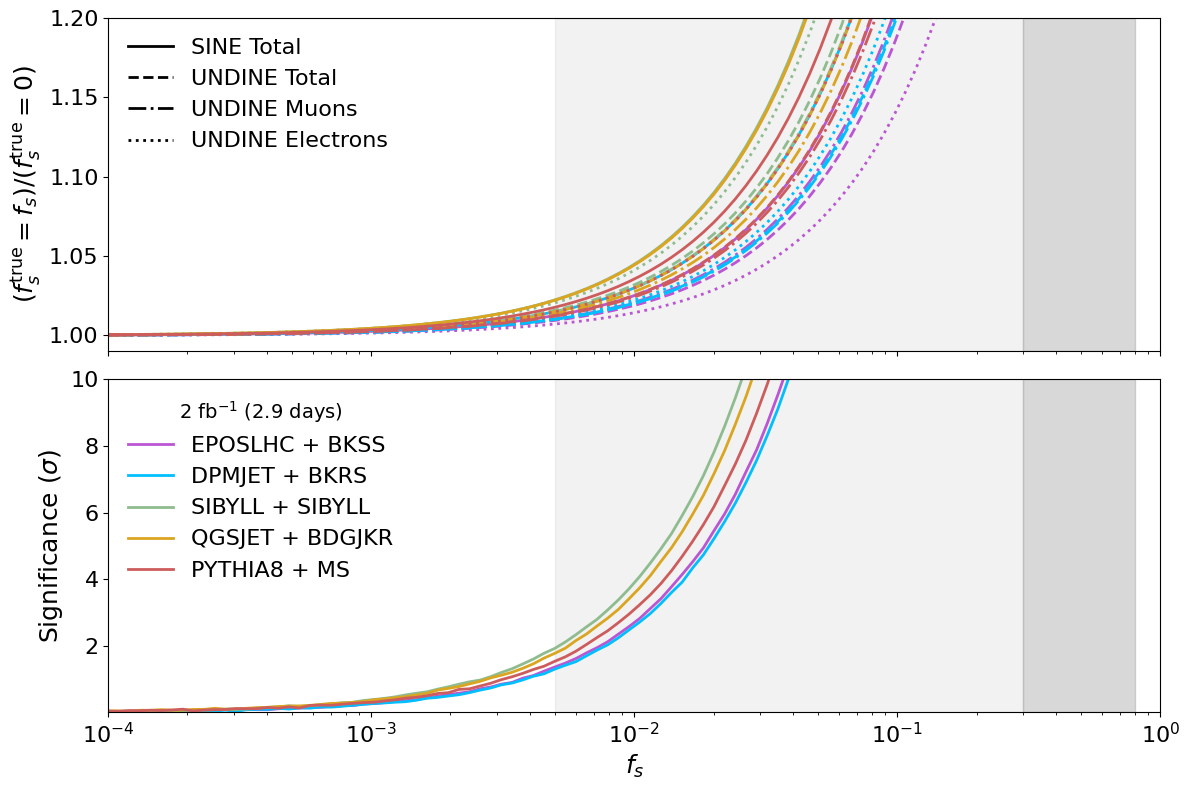

In [16]:


n_fs = 100
fs_range = np.logspace(-4,0,n_fs)
nsigma=1
low_cl = (2*(1-norm.cdf(nsigma)))
high_cl = 1 - low_cl
exposure_factor = 1./1500 # roughly one month
n_mu_samples = 1
n_k_samples = 10000
mu_mean_mode = True

fig,ax = plt.subplots(2,1,sharex=True,figsize=(12,8))
fig.subplots_adjust(hspace=0)

for lg,cg in zip(light_generators,charm_generators):
    print(lg,cg)
    c = colors[(lg,cg)]
    SINE_Total = {}
    UNDINE_Total = {}
    UNDINE_muons = {}
    UNDINE_electrons = {}
    mu_random_idxs = np.random.choice(range(len(np.load("%s/SINE_Total_%s_%s_%s.npy"%(pseudoexp_dir,"All",lg,cg)))),size=n_mu_samples)
    for k in ["All","Pions","Kaons"]:
        SINE_Total[k] = exposure_factor*np.load("%s/SINE_Total_%s_%s_%s.npy"%(pseudoexp_dir,k,lg,cg))
        UNDINE_Total[k] = exposure_factor*UNDINE_luminosity_factor*num_UNDINE*np.load("%s/UNDINE_Total_%s_%s_%s.npy"%(pseudoexp_dir,k,lg,cg))
        UNDINE_muons[k] = exposure_factor*UNDINE_luminosity_factor*num_UNDINE*np.load("%s/UNDINE_muons_%s_%s_%s.npy"%(pseudoexp_dir,k,lg,cg))
        UNDINE_electrons[k] = exposure_factor*UNDINE_luminosity_factor*num_UNDINE*np.load("%s/UNDINE_electrons_%s_%s_%s.npy"%(pseudoexp_dir,k,lg,cg))
        if mu_mean_mode:
            SINE_Total[k] = np.array([np.mean(SINE_Total[k])])
            UNDINE_Total[k] = np.array([np.mean(UNDINE_Total[k])])
            UNDINE_muons[k] = np.array([np.mean(UNDINE_muons[k])])
            UNDINE_electrons[k] = np.array([np.mean(UNDINE_electrons[k])])
        else:
            SINE_Total[k] = SINE_Total[k][mu_random_idxs]
            UNDINE_Total[k] = UNDINE_Total[k][mu_random_idxs]
            UNDINE_muons[k] = UNDINE_muons[k][mu_random_idxs]
            UNDINE_electrons[k] = UNDINE_electrons[k][mu_random_idxs]
            
    
    SINE_Total_diff = np.outer(6.6*fs_range,SINE_Total["Kaons"]) - np.outer(fs_range,SINE_Total["Pions"])
    SINE_Total_mu_null = SINE_Total["All"]
    SINE_Total_mu_alt = (np.expand_dims(SINE_Total["All"],0) + SINE_Total_diff)
    SINE_Total_k_alt = np.random.poisson(lam=np.expand_dims(SINE_Total_mu_alt,-1),size=(n_fs,n_mu_samples,n_k_samples)).reshape(n_fs,n_mu_samples*n_k_samples)
    SINE_Total_k_null = np.random.poisson(lam=np.expand_dims(SINE_Total_mu_null,-1),size=(n_mu_samples,n_k_samples)).reshape(n_mu_samples*n_k_samples)
    
    UNDINE_Total_diff = np.outer(6.6*fs_range,UNDINE_Total["Kaons"]) - np.outer(fs_range,UNDINE_Total["Pions"])
    UNDINE_Total_mu_null = UNDINE_Total["All"]
    UNDINE_Total_mu_alt = (np.expand_dims(UNDINE_Total["All"],0) + UNDINE_Total_diff)
    UNDINE_Total_k_alt = np.random.poisson(lam=np.expand_dims(UNDINE_Total_mu_alt,-1),size=(n_fs,n_mu_samples,n_k_samples)).reshape(n_fs,n_mu_samples*n_k_samples)
    UNDINE_Total_k_null = np.random.poisson(lam=np.expand_dims(UNDINE_Total_mu_null,-1),size=(n_mu_samples,n_k_samples)).reshape(n_mu_samples*n_k_samples)
    
    UNDINE_muons_diff = np.outer(6.6*fs_range,UNDINE_muons["Kaons"]) - np.outer(fs_range,UNDINE_muons["Pions"])
    UNDINE_muons_mu_null = UNDINE_muons["All"]
    UNDINE_muons_mu_alt = (np.expand_dims(UNDINE_muons["All"],0) + UNDINE_muons_diff)
    UNDINE_muons_k_alt = np.random.poisson(lam=np.expand_dims(UNDINE_muons_mu_alt,-1),size=(n_fs,n_mu_samples,n_k_samples)).reshape(n_fs,n_mu_samples*n_k_samples)
    UNDINE_muons_k_null = np.random.poisson(lam=np.expand_dims(UNDINE_muons_mu_null,-1),size=(n_mu_samples,n_k_samples)).reshape(n_mu_samples*n_k_samples)
    
    UNDINE_electrons_diff = np.outer(6.6*fs_range,UNDINE_electrons["Kaons"]) - np.outer(fs_range,UNDINE_electrons["Pions"])
    UNDINE_electrons_mu_null = UNDINE_electrons["All"]
    UNDINE_electrons_mu_alt = (np.expand_dims(UNDINE_electrons["All"],0) + UNDINE_electrons_diff)
    UNDINE_electrons_k_alt = np.random.poisson(lam=np.expand_dims(UNDINE_electrons_mu_alt,-1),size=(n_fs,n_mu_samples,n_k_samples)).reshape(n_fs,n_mu_samples*n_k_samples)
    UNDINE_electrons_k_null = np.random.poisson(lam=np.expand_dims(UNDINE_electrons_mu_null,-1),size=(n_mu_samples,n_k_samples)).reshape(n_mu_samples*n_k_samples)
    
    # print("k_alt",np.mean(SINE_Total_k_alt,axis=-1))
    # print("k_null",np.mean(SINE_Total_k_null))
    # print("mu_alt",np.mean(SINE_Total_mu_alt,axis=-1))
    # print("mu_null",np.median(SINE_Total_mu_null),np.sqrt(np.median(SINE_Total_mu_null)))
    
#     SINE_Total_mu_null = exposure_factor*SINE_rate_nominal[(lg,cg)]["All"]
#     UNDINE_Total_mu_null = exposure_factor*UNDINE_rate_nominal[(lg,cg)]["All"]
#     UNDINE_electrons_mu_null = exposure_factor*UNDINE_electrons_nominal[(lg,cg)]["All"]
#     UNDINE_muons_mu_null = exposure_factor*UNDINE_muons_nominal[(lg,cg)]["All"]
    
#     SINE_Total_mu_alt = exposure_factor*np.expand_dims(SINE_rate_nominal[(lg,cg)]["All"],0) + np.outer(6.6*fs_range,SINE_rate_nominal[(lg,cg)]["Pions"]) - np.outer(fs_range,SINE_rate_nominal[(lg,cg)]["Kaons"])
#     UNDINE_Total_mu_alt = exposure_factor*np.expand_dims(UNDINE_rate_nominal[(lg,cg)]["All"],0) + np.outer(6.6*fs_range,UNDINE_rate_nominal[(lg,cg)]["Pions"]) - np.outer(fs_range,UNDINE_rate_nominal[(lg,cg)]["Kaons"])
#     UNDINE_electrons_mu_alt = exposure_factor*np.expand_dims(UNDINE_electrons_nominal[(lg,cg)]["All"],0) + np.outer(6.6*fs_range,UNDINE_electrons_nominal[(lg,cg)]["Pions"]) - np.outer(fs_range,UNDINE_electrons_nominal[(lg,cg)]["Kaons"])
#     UNDINE_muons_mu_alt = exposure_factor*np.expand_dims(UNDINE_muons_nominal[(lg,cg)]["All"],0) + np.outer(6.6*fs_range,UNDINE_muons_nominal[(lg,cg)]["Pions"]) - np.outer(fs_range,UNDINE_muons_nominal[(lg,cg)]["Kaons"])
    
    likelihood_null_null = rate_likelihood(SINE_Total_k=np.expand_dims(SINE_Total_k_null,0),
                                           UNDINE_Total_k=np.expand_dims(UNDINE_Total_k_null,0),
                                           UNDINE_muons_k=np.expand_dims(UNDINE_muons_k_null,0),
                                           UNDINE_electrons_k=np.expand_dims(UNDINE_electrons_k_null,0),
                                           SINE_Total_mu=np.expand_dims(SINE_Total_mu_null,0),
                                           UNDINE_Total_mu=np.expand_dims(UNDINE_Total_mu_null,0),
                                           UNDINE_muons_mu=np.expand_dims(UNDINE_muons_mu_null,0),
                                           UNDINE_electrons_mu=np.expand_dims(UNDINE_electrons_mu_null,0)
                                          )
    
    #print('nn',likelihood_null_null.shape)
    
    likelihood_null_alt = rate_likelihood(SINE_Total_k=np.repeat(np.expand_dims(SINE_Total_k_null,0),n_fs,axis=0),
                                          UNDINE_Total_k=np.repeat(np.expand_dims(UNDINE_Total_k_null,0),n_fs,axis=0),
                                          UNDINE_muons_k=np.repeat(np.expand_dims(UNDINE_muons_k_null,0),n_fs,axis=0),
                                          UNDINE_electrons_k=np.repeat(np.expand_dims(UNDINE_electrons_k_null,0),n_fs,axis=0),
                                          SINE_Total_mu=SINE_Total_mu_alt,
                                          UNDINE_Total_mu=UNDINE_Total_mu_alt,
                                          UNDINE_muons_mu=UNDINE_muons_mu_alt,
                                          UNDINE_electrons_mu=UNDINE_electrons_mu_alt
                                         )
    
    #print('na',likelihood_null_alt.shape)
    
    likelihood_alt_null = rate_likelihood(SINE_Total_k=SINE_Total_k_alt,
                                          UNDINE_Total_k=UNDINE_Total_k_alt,
                                          UNDINE_muons_k=UNDINE_muons_k_alt,
                                          UNDINE_electrons_k=UNDINE_electrons_k_alt,
                                          SINE_Total_mu=np.repeat(np.expand_dims(SINE_Total_mu_null,axis=0),n_fs,axis=0),
                                          UNDINE_Total_mu=np.repeat(np.expand_dims(UNDINE_Total_mu_null,axis=0),n_fs,axis=0),
                                          UNDINE_muons_mu=np.repeat(np.expand_dims(UNDINE_muons_mu_null,axis=0),n_fs,axis=0),
                                          UNDINE_electrons_mu=np.repeat(np.expand_dims(UNDINE_electrons_mu_null,axis=0),n_fs,axis=0)
                                         )
    
    #print('an',likelihood_alt_null.shape)
    
    likelihood_alt_alt = rate_likelihood(SINE_Total_k=SINE_Total_k_alt,
                                         UNDINE_Total_k=UNDINE_Total_k_alt,
                                         UNDINE_muons_k=UNDINE_muons_k_alt,
                                         UNDINE_electrons_k=UNDINE_electrons_k_alt,
                                         SINE_Total_mu=SINE_Total_mu_alt,
                                         UNDINE_Total_mu=UNDINE_Total_mu_alt,
                                         UNDINE_muons_mu=UNDINE_muons_mu_alt,
                                         UNDINE_electrons_mu=UNDINE_electrons_mu_alt
                                        )
    
    #print('aa',likelihood_alt_alt.shape)
    
    delta_LLH_alt = likelihood_alt_alt - likelihood_alt_null
    delta_LLH_null = likelihood_null_alt - likelihood_null_null
    significance = (np.median(delta_LLH_alt,axis=-1) - np.median(delta_LLH_null,axis=-1)) / np.std(delta_LLH_null,axis=-1)
    
#     for ska,sma,utka,utma,umka,umma,ueka,uema,laa,lan,lna,dla,dln,fs in zip(
#         SINE_Total_k_alt,SINE_Total_mu_alt,
#         UNDINE_Total_k_alt,UNDINE_Total_mu_alt,
#         UNDINE_muons_k_alt,UNDINE_muons_mu_alt,
#         UNDINE_electrons_k_alt,UNDINE_electrons_mu_alt,
#         likelihood_alt_alt,likelihood_alt_null,
#         likelihood_null_alt,
#         delta_LLH_alt,delta_LLH_null,fs_range):
        
#         plt.hist(SINE_Total_k_null.flatten(),alpha=0.2,color="blue")
#         plt.hist(SINE_Total_mu_null.flatten(),alpha=1,color="blue",histtype="step")
#         plt.hist(ska.flatten(),alpha=0.2,color="orange")
#         plt.hist(sma.flatten(),alpha=1,color="orange",histtype="step")
#         plt.title(fs)
#         plt.xlabel("SINE_Total")
#         plt.semilogy()
#         plt.show()
        
#         plt.hist(UNDINE_Total_k_null.flatten(),alpha=0.2,color="blue")
#         plt.hist(UNDINE_Total_mu_null.flatten(),alpha=1,color="blue",histtype="step")
#         plt.hist(utka.flatten(),alpha=0.2,color="orange")
#         plt.hist(utma.flatten(),alpha=1,color="orange",histtype="step")
#         plt.title(fs)
#         plt.xlabel("UNDINE_Total")
#         plt.semilogy()
#         plt.show()
        
#         plt.hist(UNDINE_muons_k_null.flatten(),alpha=0.2,color="blue")
#         plt.hist(UNDINE_muons_mu_null.flatten(),alpha=1,color="blue",histtype="step")
#         plt.hist(umka.flatten(),alpha=0.2,color="orange")
#         plt.hist(umma.flatten(),alpha=1,color="orange",histtype="step")
#         plt.title(fs)
#         plt.xlabel("UNDINE_muons")
#         plt.semilogy()
#         plt.show()
        
#         plt.hist(UNDINE_electrons_k_null.flatten(),alpha=0.2,color="blue")
#         plt.hist(UNDINE_electrons_mu_null.flatten(),alpha=1,color="blue",histtype="step")
#         plt.hist(ueka.flatten(),alpha=0.2,color="orange")
#         plt.hist(uema.flatten(),alpha=1,color="orange",histtype="step")
#         plt.title(fs)
#         plt.xlabel("UNDINE_electrons")
#         plt.semilogy()
#         plt.show()
        
#         # plt.hist(laa,histtype="step",label="laa")
#         # plt.hist(lan,histtype="step",label="lan")
#         # plt.hist(lna,histtype="step",label="lna")
#         # plt.hist(likelihood_null_null[0],histtype="step",label="lnn")
#         # plt.legend()
#         # plt.semilogy()
#         # plt.show()
#         plt.hist(dla,histtype="step",label="dla")
#         plt.hist(dln,histtype="step",label="dln")
#         plt.legend()
#         plt.semilogy()
#         plt.show()
    
    # discovery_potential = np.count_nonzero(np.less(likelihood_null,np.expand_dims(np.median(likelihood_alt,axis=-1),axis=-1)),axis=-1) / likelihood_null.shape[-1]
    # print(discovery_potential)
    
    #plt.hist(LLH)
    
    r1 = SINE_Total_mu_alt/SINE_Total_mu_null
    r2 = UNDINE_Total_mu_alt/UNDINE_Total_mu_null
    r3 = UNDINE_muons_mu_alt/UNDINE_muons_mu_null
    r4 = UNDINE_electrons_mu_alt/UNDINE_electrons_mu_null
    
    #if "SIBYLL" in lg:
    ax[0].plot(fs_range,np.median(r1,axis=-1),color=c)
    ax[0].plot(fs_range,np.median(r2,axis=-1),color=c,ls="--")
    ax[0].plot(fs_range,np.median(r3,axis=-1),color=c,ls="-.")
    ax[0].plot(fs_range,np.median(r4,axis=-1),color=c,ls=":")
    ax[1].plot([],[],color=c,label="%s + %s"%(lg,cg))
    ax[1].plot(fs_range,significance,color=c)
    
ax[0].semilogx()
ax[1].semilogx()
ax[0].set_ylim(0.99,1.2)
ax[1].set_ylim(0.01,10)
ax[1].set_xlim(fs_range[0],fs_range[-1])
ax[1].set_xlabel(r"$f_s$")
ax[0].set_ylabel(r"$(f_s^{\rm true} = f_s)/(f_s^{\rm true} = 0)$")
ax[1].set_ylabel(r"Significance ($\sigma$)")
ax[0].plot([],[],color="black",label="SINE Total")
ax[0].plot([],[],color="black",label="UNDINE Total",ls="--")
ax[0].plot([],[],color="black",label="UNDINE Muons",ls="-.")
ax[0].plot([],[],color="black",label="UNDINE Electrons",ls=":")
for i in range(2):
    ax[i].axvspan(0.3,0.8,color="grey",alpha=0.3)
    ax[i].axvspan(0.005,0.3,color="grey",alpha=0.1)
ax[0].legend(loc="upper left")
ax[1].legend(title=r"%d ${\rm fb}^{-1}$ (%2.1f days)"%(3000*exposure_factor,exposure_factor/yearly_factor*365),loc="upper left")
plt.tight_layout()
plt.savefig("Figures/SIREN/StrangenessEnhancement.pdf",dpi=100)
plt.show()
    

In [17]:
test = ak.from_parquet("/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/Geneva/Lake_Geneva_Neutrinos/Data/SIREN/Output/UNDINE_LHCb_North/LHC13_EPOSLHC_light_-12_CC_TEST.parquet")
#test = ak.from_parquet("/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/Geneva/Lake_Geneva_Neutrinos/Data/SIREN/Output/UNDINE_CMS_East/LHC13_EPOSLHC_light_12_CC_TEST.parquet")

test.int_probs

ValueError: no *.parquet or *.parq matches for path '/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/Geneva/Lake_Geneva_Neutrinos/Data/SIREN/Output/UNDINE_LHCb_North/LHC13_EPOSLHC_light_-12_CC_TEST.parquet'

This error occurred while calling

    ak.from_parquet(
        '/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/Ge'...
    )

In [ ]:
weights = test.weights*num_UNDINE*np.array(test.in_fiducial)[:,-1]
print(sum(weights))
print(sum(np.array(test.in_fiducial)[:,-1])/len(test.in_fiducial))
print(sum(weights)/(sum(np.array(test.in_fiducial)[:,-1])/len(test.in_fiducial)))
plt.hist(test.energy,weights=weights,bins=np.logspace(1,4,30))
plt.loglog()
plt.ylim(1e0,1e5)
plt.show()

In [ ]:
plt.hist(test.int_probs[np.array(test.in_fiducial)[:,-1]],alpha=0.5,bins=np.logspace(-20,10,50))
plt.hist(test.int_probs[np.logical_not(np.array(test.in_fiducial)[:,-1])],alpha=0.5,bins=np.logspace(-20,10,50))
plt.loglog()

In [ ]:
philip_xsdir = "/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/Geneva/Lake_Geneva_Neutrinos/Data/SIREN/CrossSections"
x = pd.read_csv("%s/xs_wcg24b_isoscalar.txt"%philip_xsdir)
x.keys()

In [ ]:
for pstr in ["NUMU","NUTAU"]:
    fig,ax = plt.subplots(2,1,sharex=True)
    fig.subplots_adjust(hspace=0)
    for xs_mode in ["CC","NC"]:
        for particle,color in zip(["%s"%pstr,"%sBAR"%pstr],
                                  ["orangered","dodgerblue"]):
            xs = x["%s_%s[CM2]"%(particle,xs_mode)]*1e-36 # pb to cm2
            unc = x["UNC_%s_%s[%%]"%(particle,xs_mode)]
            ls = "-" if xs_mode=="CC" else "--"
            ax[0].plot(x["E[GEV]"],xs,ls=ls,color=color)
            #ax[1].plot(x["E[GEV]"],(1-unc/100),color=color,ls=ls)
            ax[1].plot(x["E[GEV]"],(unc),color=color,ls=ls,label="%s %s"%(particle,xs_mode))
    ax[0].loglog()
    ax[1].semilogx()
    ax[1].set_xlim(list(x["E[GEV]"])[0],list(x["E[GEV]"])[-1])
    ax[1].legend(ncol=2)
    plt.show()

In [ ]:
data_test = data[('SINE_CMS_West', 'CC', 'LHC13', 'DPMJET', 'light', 14)]
data_test["panel_hit"] = np.where(data_test.panel1_hit_mask_muon_survival,1,
                               np.where(data_test.panel2_hit_mask_muon_survival,2,
                                        np.where(data_test.panel3_hit_mask_muon_survival,3,0)))
data_test
hit_location = [x["panel%d_int_locations"%x.panel_hit][0] for x in data_test]